In [1]:
import linecache
import numpy as np
import matplotlib.pyplot as plt
import dynaphopy.interface.iofile as io
import dynaphopy.projection as projection
import dynaphopy.parameters as parameters
import dynaphopy.interface.phonopy_link as pho_interface
import dynaphopy.interface.iofile as reading
import dynaphopy.analysis.energy as energy
import dynaphopy.analysis.fitting as fitting
import dynaphopy.analysis.modes as modes
import dynaphopy.analysis.coordinates as trajdist
import dynaphopy.analysis.thermal_properties as thm
import dynaphopy.interface.iofile.trajectory_parsers as parsers

from dynaphopy.power_spectrum import power_spectrum_functions
from scipy import constants
from scipy import integrate
from tqdm import tqdm
from scipy.integrate import simps
import os
import numpy as np
import dynaphopy.interface.iofile as io
import dynaphopy
from dynaphopy.interface.phonopy_link import get_force_constants_from_file
import phonopy
import yaml
from phonopy import PhonopyQHA
from phonopy.file_IO import read_v_e, write_FORCE_CONSTANTS
# from dynaphopy.interface.phonopy_link import get_force_constants_from_file
from pymatgen.core.structure import Structure
from sumo.plotting.phonon_bs_plotter import SPhononBSPlotter
from pymatgen.phonon.plotter import PhononDosPlotter
from pymatgen.io.phonopy import get_phonon_dos_from_fc, get_phonon_band_structure_symm_line_from_fc
from sumo.phonon import phonopy as ph
import matplotlib.pyplot as plt
from pymatgen.core.periodic_table import Element
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import matplotlib
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
import xarray as xr
from pymatgen.util.coord import pbc_shortest_vectors

In [2]:
# !pip install xarray --user

In [3]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # plt.register_cmap(cmap=newcmap)

    return newcmap

In [4]:
from sumo.phonon import phonopy as ph
from pymatgen.core.structure import Structure
import matplotlib.pyplot

import sumo.plotting
import sumo.plotting.dos_plotter
from sumo.plotting.dos_plotter import get_cached_colour
import os,subprocess 
from pymatgen.core.periodic_table import Element
from pymatgen.io.phonopy import get_phonon_dos_from_fc
from pymatgen.phonon.plotter import PhononDosPlotter
import numpy as np
import pandas as pd
import os,subprocess 
import copy 
%matplotlib inline

In [5]:
# !pip install seekpath --user

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib import lines
from mpl_toolkits.mplot3d import proj3d
import numpy as np


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0.0, 0.0), (0.0, 0.0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)


def plot_phonon_modes1(structure, eigenvectors, q_vector,
                      supercell=(1, 1, 1),
                      draw_primitive=False,
                      vectors_scale=10,
                      by_element=True):

    atom_type = structure.get_atom_type_index(supercell=supercell)
    positions = structure.get_positions(supercell=supercell)
    masses = structure.get_masses(supercell=supercell)
    elements = structure.get_atomic_elements(supercell=supercell)
    np.set_printoptions(precision=8, suppress=True)

    cell_t = structure.get_cell()
    if draw_primitive:
        cell_t = structure.get_primitive_cell()

    for i_phonon in range(eigenvectors.shape[0]):

        fig = plt.figure(i_phonon+1)
        if draw_primitive:
            fig.suptitle('Primitive cell')
        else:
            fig.suptitle('Unit cell')

        ax = fig.add_subplot(111, projection='3d')

        color_atom=['g','b','m', 'c', 'y', 'k', 'w', 'g', 'b', 'm', 'c', 'y', 'k', 'w','g','b','m', 'c', 'y',
                    'k', 'w', 'g', 'b', 'm', 'c', 'y', 'k', 'w','g','b','m', 'c', 'y', 'k', 'w', 'g', 'b']

        if by_element:
            elements_unique = np.unique(elements, return_inverse=True)[1]
        else:
            elements_unique = atom_type

        # Atom positions
        for i, atom in enumerate(positions):
            ax.plot(atom[0][None], atom[1][None], atom[2][None], 'o', markersize=atom_radius[elements[i]]*30, color=color_atom[elements_unique[i]], alpha=0.8)

        # Cell frame
        for i in range(3):
            cell_side = [(0, cell_t[i, 0]), (0, cell_t[i, 1]), (0, cell_t[i, 2])]
            ax.plot3D(*cell_side, color='b')
            for j in range(3):
                if i != j:
                    cell_side = [(cell_t[i, l],
                                  cell_t[i, l]+cell_t[j, l]) for l in range(3)]

                    ax.plot3D(*cell_side, color='b')
                    for k in range(3):
                        if k != i and k != j and j > i:
                            cell_side = [(cell_t[i, l]+cell_t[j, l],
                                          cell_t[i, l]+cell_t[j, l]+cell_t[k, l]) for l in range(3)]

                            ax.plot3D(*cell_side, color='b')

        # Atom positions
        for i, position in enumerate(positions):
            eigenvector_atom = np.array(eigenvectors[i_phonon, atom_type[i], :])
            phase = 1.j * np.dot(position, q_vector)
            vector = (eigenvector_atom / np.sqrt(masses[atom_type[i]]) * np.exp(phase) * vectors_scale).real
 #           vector = np.dot(vector, np.linalg.inv(structure.get_primitive_matrix().T))
            a = Arrow3D([position[0], position[0]+vector[0]], [position[1], position[1]+vector[1]],
                        [position[2], position[2]+vector[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
            ax.add_artist(a)

        # Legend
        atom_type_index_unique = np.unique(atom_type, return_index=True)[0]



        if by_element:
            atomic_types_unique = np.unique(elements, return_inverse=True)[0]
        else:
            atomic_types_unique = [elements[i] for i in atom_type_index_unique]

        legend_atoms =  [ lines.Line2D([0],[0], linestyle='none', c=color_atom[i], marker='o') for i, element in enumerate(atomic_types_unique)]
        ax.legend(legend_atoms, atomic_types_unique, numpoints = 1)

        # ax.set_axis_off()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.title('Phonon {0}'.format(i_phonon+1))
        plt.axis('auto')
    plt.show()

    return


def analysis_phonon_modes(structure, eigenvectors, q_vector,
                      supercell=(1, 1, 1),
                      draw_primitive=False,
                      vectors_scale=10,
                      by_element=True,frequencies=[]):
    
    atom_type = structure.get_atom_type_index(supercell=supercell)
    positions = structure.get_positions(supercell=supercell)
    masses = structure.get_masses(supercell=supercell)
    elements = structure.get_atomic_elements(supercell=supercell)
    np.set_printoptions(precision=8, suppress=True)
    vectors_phonon_list = []
    num_phonon_list = []
    freqency_list1 = []
    effect_migration_phonon_list_total = []
    if by_element:
        elements_unique = np.unique(elements, return_inverse=True)[1]
    else:
        elements_unique = atom_type
    for i_phonon in range(eigenvectors.shape[0]):

#         if draw_primitive:
#             fig.suptitle('Primitive cell')
#         else:
#             fig.suptitle('Unit cell')


        color_atom=['g','b','m', 'c', 'y', 'k', 'w', 'g', 'b', 'm', 'c', 'y', 'k', 'w','g','b','m', 'c', 'y',
                    'k', 'w', 'g', 'b', 'm', 'c', 'y', 'k', 'w','g','b','m', 'c', 'y', 'k', 'w', 'g', 'b']

        if by_element:
            elements_unique = np.unique(elements, return_inverse=True)[1]
        else:
            elements_unique = atom_type

        # Atom positions
#         for i, atom in enumerate(positions):
#             ax.plot(atom[0][None], atom[1][None], atom[2][None], 'o', markersize=atom_radius[elements[i]]*30, color=color_atom[elements_unique[i]], alpha=0.8)

        # Cell frame
#         for i in range(3):
#             cell_side = [(0, cell_t[i, 0]), (0, cell_t[i, 1]), (0, cell_t[i, 2])]
#             ax.plot3D(*cell_side, color='b')
#             for j in range(3):
#                 if i != j:
#                     cell_side = [(cell_t[i, l],
#                                   cell_t[i, l]+cell_t[j, l]) for l in range(3)]

#                     ax.plot3D(*cell_side, color='b')
#                     for k in range(3):
#                         if k != i and k != j and j > i:
#                             cell_side = [(cell_t[i, l]+cell_t[j, l],
#                                           cell_t[i, l]+cell_t[j, l]+cell_t[k, l]) for l in range(3)]

#                             ax.plot3D(*cell_side, color='b')

        # Atom positions
        anion_atom_index_list = {'Al-Ga-In':
                   [
                   [[0.00000,  0.50000,  0.25000],[0.00000,  0.00000,  0.50000]],
                   [[1.00000,  0.50000,  0.25000],[1.00000,  1.00000,  0.50000]],
                   [[0.50000,  1.00000,  0.75000],[0.00000,  1.00000,  0.50000]],
                   [[0.50000,  0.00000,  0.75000],[1.00000,  0.00000,  0.50000]],
                   [[0.50000,  0.00000,  0.75000],[0.50000,  0.50000,  0.00000]],
                   [[0.50000,  0.50000,  0.00000],[0.50000,  1.00000,  0.75000]],
                   [[1.00000,  0.50000,  0.25000],[0.50000,  0.50000,  1.00000]],
                   [[0.50000,  0.50000,  1.00000],[0.00000,  0.50000,  0.25000]]
                  ],'Sc-Y-La':[[[0.000000000, 0.500000000,0.250000000],[0.000000000,1.000000000,0.000000000]],
                   [[0.000000000,0.500000000,0.250000000],[0.000000000,0.000000000,0.000000000]],
                   [[1.00000,  1.00000,  1.00000],[0.50000,  1.00000,  0.75000]],
                   [[0.00000,  0.00000,  1.00000],[0.50000,  0.00000,  0.75000]],
                   [[0.50000,  1.00000,  0.75000],[0.50000,  0.50000,  0.50000]],
                   [[0.50000,  0.50000,  0.50000],[0.50000,  0.00000,  0.75000]],
                   [[0.00000,  0.50000,  0.25000],[0.50000,  0.50000,  0.50000]],
                   [[0.50000,  0.50000,  0.50000],[1.00000,  0.50000,  0.25000]]
                  ]} 
        index = 0
        effect_migration_phonon_list = []
        for i, position in enumerate(positions):
            if elements[i]=='Li':
                print(elements[i])

                print(index)
                
                eigenvector_atom = np.array(eigenvectors[i_phonon, atom_type[i], :])
                phase = 1.j * np.dot(position, q_vector)
                vector = (eigenvector_atom / np.sqrt(masses[atom_type[i]]) * np.exp(phase) * vectors_scale).real
                
                position_Li = np.dot(anion_atom_index_list['Al-Ga-In'],structure.get_cell())
                vector_li1  = position_Li[index][0]-position
                theta1 = np.dot(vector/np.linalg.norm(vector),vector_li1/np.linalg.norm(vector_li1))
                vector_li2  = position_Li[index][1]-position
                theta2 = np.dot(vector/np.linalg.norm(vector),vector_li2/np.linalg.norm(vector_li2))
                theta = max(np.abs(theta1),np.abs(theta2))
                index =index+1
                if theta > 0.77780455799:
                    effect_migration_phonon_list.append(np.linalg.norm(vector)*theta)
                    freqency_list1.append(frequencies[i_phonon])
                    effect_migration_phonon_list_total.append(np.linalg.norm(vector)*theta)
                else:
                    effect_migration_phonon_list.append(0)
 #           vector = np.dot(vector, np.linalg.inv(structure.get_primitive_matrix().T))
#             a = Arrow3D([position[0], position[0]+vector[0]], [position[1], position[1]+vector[1]],
#                         [position[2], position[2]+vector[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
#             ax.add_artist(a)
        vectors_phonon_list.append(np.mean([i for i in effect_migration_phonon_list]))
        num_phonon_list.append(len([i for i in effect_migration_phonon_list if i is not 0])/8)
        # Legend
#         atom_type_index_unique = np.unique(atom_type, return_index=True)[0]



#         if by_element:
#             atomic_types_unique = np.unique(elements, return_inverse=True)[0]
#         else:
#             atomic_types_unique = [elements[i] for i in atom_type_index_unique]
    
    
    return vectors_phonon_list,num_phonon_list,freqency_list1,effect_migration_phonon_list_total
    
atom_radius = {
    'H':0.32,
    'He':0.93,
    'Li':1.23,
    'Be':0.9,
    'B':0.82,
    'C':0.77,
    'N':0.75,
    'O':0.73,
    'F':0.72,
    'Ne':0.71,
    'Na':1.54,
    'Mg':1.36,
    'Al':1.18,
    'Si':1.11,
    'P':1.06,
    'S':1.02,
    'Cl':0.99,
    'Ar':0.98,
    'K':2.03,
    'Ca':1.74,
    'Sc':1.44,
    'Ti':1.32,
    'V':1.22,
    'Cr':1.18,
    'Mn':1.17,
    'Fe':1.17,
    'Co':1.16,
    'Ni':1.15,
    'Cu':1.17,
    'Zn':1.25,
    'Ga':1.26,
    'Ge':1.22,
    'As':1.2,
    'Se':1.16,
    'Br':1.14,
    'Kr':1.12,
    'Rb':2.16,
    'Sr':1.91,
    'Y':1.62,
    'Zr':1.45,
    'Nb':1.34,
    'Mo':1.3,
    'Tc':1.27,
    'Ru':1.25,
    'Rh':1.25,
    'Pd':1.28,
    'Ag':1.34,
    'Cd':1.48,
    'In':1.44,
    'Sn':1.41,
    'Sb':1.4,
    'Te':1.36,
    'I':1.33,
    'Xe':1.31,
    'Cs':2.35,
    'Ba':1.98,
    'La':1.69,
    'Ce':1.65,
    'Pr':1.65,
    'Nd':1.64,
    'Pm':1.63,
    'Sm':1.62,
    'Eu':1.85,
    'Gd':1.61,
    'Tb':1.59,
    'Dy':1.59,
    'Ho':1.58,
    'Er':1.57,
    'Tm':1.56,
    'Yb':1.74,
    'Lu':1.56,
    'Hf':1.44,
    'Ta':1.34,
    'W':1.3,
    'Re':1.28,
    'Os':1.26,
    'Ir':1.27,
    'Pt':1.3,
    'Au':1.34,
    'Hg':1.49,
    'Tl':1.48,
    'Pb':1.47,
    'Bi':1.46,
    'Po':1.46,
    'At':1.45,
    'Rn':0.0,
    'Fr':0.0,
    'Ra':0.0,
    'Ac':0.0,
    'Th':1.65,
    'Pa':0.0,
    'U':1.42,
    'Np':0.0,
    'Pu':0.0,
    'Am':0.0,
    'Cm':0.0,
    'Bk':0.0,
    'Cf':0.0,
    'Es':0.0,
    'Fm':0.0,
    'Md':0.0,
    'No':0.0,
    'Lr':0.0,
    'Rf':0.0,
    'Db':0.0,
    'Sg':0.0,
    'Bh':0.0,
    'Hs':0.0,
    'Mt':0.0,
}

In [7]:
def analyze_anharmonic_phonon_modes(structure, eigenvectors,q_vector,velocities,
                      supercell=(1, 1, 1),
                      draw_primitive=False,
                      vectors_scale=10,
                      by_element=True):

    atom_type = structure.get_atom_type_index(supercell=supercell)
    positions = structure.get_positions(supercell=supercell)
    masses = structure.get_masses(supercell=supercell)
    elements = structure.get_atomic_elements(supercell=supercell)
    np.set_printoptions(precision=8, suppress=True)
    
    Li_index_list = []
    Li_index_list1 = []
    for i, position in enumerate(positions):
        if elements[i]=='Li':
            Li_index_list.append(atom_type[i])
            Li_index_list1.append(i)
    print(Li_index_list)
    velocities_list = []
    vectors_phonon_list = []
    num_phonon_list = []
    freqency_list1 = []
    effect_migration_phonon_list_total = []
#     center_mass_velocity_list  =[]
#     print(velocities.shape[0])
    vc_t_i_n = np.zeros((velocities.shape[0],eigenvectors.shape[0],3))
    vc_t_i_n1 = np.zeros((velocities.shape[0],eigenvectors.shape[0],3))
    temp=300 # Temp = 300k
    for velo in tqdm(range(velocities.shape[0])):
        for i_phonon in range(eigenvectors.shape[0]):
            center_mass_velocity_list = []
            center_mass_velocity_list1 = []
            phase = 1.j * np.dot(position, q_vector)
            eigenvector_atom_1 = np.array(eigenvectors[i_phonon, Li_index_list, :])
            velocity_atom_1 = velocities[velo,Li_index_list,:] 
            vector_lst = eigenvector_atom_1*np.exp(phase).real
            norm =1/np.linalg.norm(vector_lst,axis=1)
            vector_lst = vector_lst
            q_n_list = []
            # print(vector_lst)
            for id1 in Li_index_list1:
                q_n_list.append(np.dot(vector_lst[id1],velocity_atom_1[id1]))
            q_n_1 = np.sum(q_n_list)
            for i, position in enumerate(positions):
                if elements[i]=='Li':
  
                    eigenvector_atom = np.array(eigenvectors[i_phonon, atom_type[i], :])
                    # print(eigenvector_atom_1)
                    # print(eigenvector_atom)
                    
                    vector = eigenvector_atom * np.exp(phase).real
                    vector_1 = vector#/np.linalg.norm(vector)
                    
                    #*np.array([norm,norm,norm]).T
                    # print(np.linalg.norm(vector_list[0]))
                    vector_norm = vector_1#*np.sqrt(2*constants.k*temp)/np.sqrt(masses[atom_type[i]]/constants.N_A/1000)/100
#                     print(i)
                    
                    
                    velocity_atom1 = velocities[velo,atom_type[i],:] #-vector_norm

                    #q_n_list_abs = np.abs(q_n_list)
                    # print(q_n_list)
#                     for i_phonon1 in range(eigenvectors.shape[0]):
#                         eigenvector_atom1 = np.array(eigenvectors[i_phonon1, atom_type[i], :])
#                         phase1 = 1.j * np.dot(position, q_vector)
#                         vector1 = eigenvector_atom * np.exp(phase1).real
#                         vector_2 = vector1/np.linalg.norm(vector1)
#                         q_n = np.dot(velocity_atom1,vector_2)
#                         q_n_list.append(q_n)
                    
                    
                    # print(q_n_1)
                    velocity_atom =  q_n_1*vector_norm
                    # print(np.linalg.norm(velocity_atom1))
                    # print(np.linalg.norm(q_n_1*vector_norm))
                    # print(q_n_1*vector_norm)
#                     print(masses[atom_type[i]]/constants.N_A)
                    # print(velocity_atom)
                    
                    center_mass_velocity_list.append(velocity_atom)
#                     center_mass_velocity_list
                    center_mass_velocity_list1.append(velocity_atom1)
    
    
    
            center_mass_velocity = np.mean(center_mass_velocity_list,axis=0)
            center_mass_velocity1 = np.mean(center_mass_velocity_list1,axis=0)
            center_mass_velocity_norm = np.linalg.norm(center_mass_velocity)
            vc_t_i_n[velo][i_phonon] = center_mass_velocity
            vc_t_i_n1[velo][i_phonon] = center_mass_velocity1
 #           vector = np.dot(vector, np.linalg.inv(structure.get_primitive_matrix().T))
#             a = Arrow3D([position[0], position[0]+vector[0]], [position[1], position[1]+vector[1]],
#                         [position[2], position[2]+vector[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
#             ax.add_artist(a)
        # Legend
#         atom_type_index_unique = np.unique(atom_type, return_index=True)[0]



#         if by_element:
#             atomic_types_unique = np.unique(elements, return_inverse=True)[0]
#         else:
#             atomic_types_unique = [elements[i] for i in atom_type_index_unique]
    
    
    return vc_t_i_n,vc_t_i_n1

In [8]:
from scipy import signal
def calc_ACF(array_1D1,array_1D2):
    # Normalization
#     yunbiased = array_1D1 - np.mean(array_1D1, axis=0)
#     ynorm = np.sum(np.power(yunbiased,2), axis=0)
#    print("the average value of input data array", ynorm)
    vaf2 = np.zeros((len(array_1D1))*2 - 1)
    for j in range(3):
        vaf2 += np.correlate(array_1D1[:,j],
                                          array_1D2[:,j], 
                                          'full')
    vaf = vaf2#/(np.sqrt(np.sum(array_1D1[:,j]**2))*np.sqrt(np.sum(array_1D2[:,j]**2)))
    vaf1 = vaf[len(array_1D1)-1:-1]
    total1 = np.sum(vaf1)
    return total1


In [9]:
from scipy import signal
def calc_ACF(array_1D1,array_1D2):
    # Normalization
#     yunbiased = array_1D1 - np.mean(array_1D1, axis=0)
#     ynorm = np.sum(np.power(yunbiased,2), axis=0)
#    print("the average value of input data array", ynorm)
    vaf2 = np.zeros((len(array_1D1))*2 - 1)
    for j in range(3):
        vaf2 += signal.fftconvolve(array_1D1[:,j],
                                          array_1D2[:,j], 
                                          'valid')
    vaf = vaf2#/(np.sqrt(np.sum(array_1D1[:,j]**2))*np.sqrt(np.sum(array_1D2[:,j]**2)))
    vaf1 = vaf[len(array_1D1)-1:]
    print
    total1 = np.sum(vaf1)
    return total1


In [10]:
#!/usr/bin/env python

''' ----------------------------------------------------------------------------------------
vacf.py is a code for calculating self-diffusion coefficients from molecular 
dynamics (MD) simulations. The self-diffusion coefficients are computed from 
velocity auto-correlation functions (VACF) using the Green-Kubo expression.

Open-source free software under GNU GPL v3
Copyright (C) 2022-2024 Omid Shayestehpour

Please cite: J. Phys. Chem. B 2022, 126, 18, 3439–3449. (DOI 10.1021/acs.jpcb.1c10671)
---------------------------------------------------------------------------------------- '''

import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import integrate
from scipy.optimize import curve_fit
from tqdm import trange

def acf(velocities,velocities2):
    # define VACF using FFT
    # particles = velocities.shape[0]
    steps = velocities.shape[0]
    lag = steps // 2

    # nearest size with power of 2 (for efficiency) to zero-pad the input data
    size = 2 ** np.ceil(np.log2(2*steps - 1)).astype('int')

    vacf = np.zeros((1, lag), dtype=np.float32)
    for i in range(1):

        # compute the FFT
        Xfft = np.fft.fft(velocities[:, 0], size)
        Yfft = np.fft.fft(velocities[:, 1], size)
        Zfft = np.fft.fft(velocities[:, 2], size)
        Xfft2 = np.fft.fft(velocities2[:, 0], size)
        Yfft2 = np.fft.fft(velocities2[:, 1], size)
        Zfft2 = np.fft.fft(velocities2[:, 2], size)
        # get the power spectrum
        Xpwr = Xfft.conjugate() * Xfft2
        Ypwr = Yfft.conjugate() * Yfft2
        Zpwr = Zfft.conjugate() * Zfft2

        # calculate the auto-correlation from inverse FFT of the power spectrum
        Xcorr = np.fft.ifft(Xpwr)[:steps].real
        Ycorr = np.fft.ifft(Ypwr)[:steps].real
        Zcorr = np.fft.ifft(Zpwr)[:steps].real

        autocorrelation = (Xcorr + Ycorr + Zcorr) / np.arange(steps, 0, -1)

        vacf[i] = autocorrelation[:lag]

    return np.mean(vacf, axis=0)

def diffusion(vacf, time, timestep):
    # integrate the VACF and calculate the self-diffusion coefficient from Green-Kubo relation
    timestep = timestep * 10**(-12)
    integral = integrate.cumtrapz(y=vacf/3, dx=timestep, initial=0)
    # print(integral)

    # fitting an exponential function to the running integral
    def func(x, a, b, c):
        return a + b * np.exp(c*(-x))

    # initial guess of the fitting parameters
    initialGuess = [1.0, 1.0, 1.0]  

    # perform curve fitting
    opt, cov = curve_fit(func, time[:integral.shape[0]], integral[:], initialGuess,maxfev=10000)
    residuals = integral[:] - func(time[:integral.shape[0]], *opt)
    ssRes = np.sum(residuals**2)
    ssTot = np.sum((integral[:] - np.mean(integral[:]))**2)
    Rsqrd = 1 - (ssRes / ssTot)

    # save the running integral of VACF and the fitted curve as CSV files
    df = pd.DataFrame({"time [ps]" : time[:integral.shape[0]]})
    df['self-diffusion coefficient [m^2/s]'] = integral[:]
    df['fit'] = func(time[:integral.shape[0]], *opt)
    # df.to_csv("sd.csv", index=False)

    # save fitting results (i.e. self-diffusion coefficients) to a file
    # with open('sd.out', 'w') as out:
    #     out.write('exponential fit: ' + '\n')
    #     out.write('  D(t) = %e + %e * exp(-t * %e) (units: D = [m^2/s], t = [s])' % tuple(opt) + '\n')
    #     out.write('  R^2 = %f   (correlation coefficient)' % Rsqrd + '\n\n')
    #     out.write('Diffusion coefficient = %f pm^2/ps  = %e m^2/s' % (opt[0]*(10**12), opt[0]) + '\n')

    return integral, opt, func

def save_vacf(vacf, time):
    # save the VACF as a CSV file
    df = pd.DataFrame({"time [ps]" : time[:vacf.shape[0]], "VACF" : vacf/vacf[0]})
    df.to_csv("vacf.csv", index=False)

def plot_vacf(vacf, time):
    # plot the VACF
    pyplot.figure(figsize=(10,5))
    pyplot.plot(time[:vacf.shape[0]], vacf/vacf[0], label='vacf')
    pyplot.xlabel('time [ps]')
    pyplot.ylabel('⟨v(0).v(t)⟩')
    pyplot.legend()
    pyplot.show()

def plot_diffusion(integral, opt, func, time):
    # plot the running integral of VACF and fitted curve
    time = time[:integral.shape[0]]
    pyplot.figure(figsize=(10,5))
    pyplot.plot(time, integral, label='self-diffusion')
    pyplot.plot(time, func(time, *opt), label='fit', linestyle='dashed')
    pyplot.xlabel('time [ps]')
    pyplot.ylabel('D [m^2/s]')
    pyplot.legend()
    pyplot.show()

In [52]:
list1 = ['Al-Se']
temp =900
for i1 in list1:
    structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon1/POSCAR')

    # structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd_50000/POSCAR')
    # structure = io.read_from_file_structure_outcar('./LiM_MO3_2/{i1}/aimd-fix2/300//OUTCAR')

    structure.set_primitive_matrix([[1, 0, 0],
                                         [0, 1, 0],
                                         [0, 0, 1]])
    # structure_pymatgen = Structure.from_file(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd_50000/POSCAR')

    structure_pymatgen = Structure.from_file(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon1/POSCAR')
    structure.set_force_constants(get_force_constants_from_file(file_name=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon1/FORCE_CONSTANTS',
                                                                     fc_supercell=[[1, 0, 0],
                                                                                   [0, 1, 0],
                                                                                   [0, 0, 1]]))
    # trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd_50000/{temp}/XDATCAR', structure, time_step=0.001)
    # trajectory = io.generate_test_trajectory(structure, supercell=[1, 1, 1], total_time=10, silent=False)
    # trajectory = parsers.read_lammps_trajectory(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/MTP_process/lammps/out.dump',structure,time_step=0.001)
    calculation = dynaphopy.Quasiparticle(trajectory,last_steps=50000)
    calculation.select_power_spectra_algorithm(2)
#     renormalized_force_constants = calculation.get_renormalized_force_constants()
#     # harmonic_force_constants = calculation.dynamic.structure.get_force_constants()
#     # calculation.get_thermal_properties() 

#     # calculation.write_atomic_displacements([0, 0, 1], 'atomic_displacements.dat')
# #     calculation.write_quasiparticles_data(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/quasiparticles_data.yaml')
# #     calculation.write_renormalized_phonon_dispersion_bands(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/bands_data.yaml')
#     calculation.plot_dos_phonopy(force_constants=renormalized_force_constants)
#     calculation.plot_renormalized_phonon_dispersion_bands()
# reference = np.loadtxt('Si_data/atomic_displacements.dat')
# data = np.loadtxt('atomic_displacements.dat')
# test_range = np.arange(-5, 5, 0.1)

Reading VASP POSCAR structure
Reading LAMMPS trajectory
This could take long, please wait..
No velocity provided! calculating it from coordinates...
MD cell size relation: [1 1 1]
Using 50000 steps
Using Fast Fourier transform (Numpy) function


In [53]:
step = 10
a1,a2 = analyze_anharmonic_phonon_modes(structure=calculation.dynamic.structure,
                                eigenvectors=calculation.get_eigenvectors(),
                                q_vector=calculation.get_q_vector(),velocities=calculation.dynamic.velocity[0:-1:step])

Harmonic frequencies (THz):
[-0.01946315 -0.01641735 -0.01631778  1.47370162  1.50227378  1.50227456
  1.76665785  1.76665828  2.11840791  2.11840854  2.14673104  2.44222084
  2.64288941  2.64288975  2.65661517  2.65661555  2.84094559  2.85144007
  2.91568654  2.91568699  3.109744    3.1097441   3.16638424  3.31704421
  3.31704448  3.62097321  3.62097357  3.73391356  3.73391368  3.88888235
  3.92165575  3.9216558   3.96604209  3.9660422   3.9797466   3.97974674
  4.14327482  4.14327493  4.37368962  4.37368987  4.39133325  4.42961997
  4.5557357   4.8240999   4.82410005  4.83872326  4.83872359  5.00251407
  5.02400239  5.02400256  5.17370128  5.17370143  5.25119888  5.37624348
  5.41273096  5.41273124  5.99278311  6.13384821  6.13384829  6.17979235
  6.17979246  6.26846754  6.39440237  6.55103107  6.55103121  6.55479159
  6.55479167  6.61366975  6.6136698   6.6140164   6.61401662  6.76844696
  6.82612467  6.82612472  6.87088375  6.99677961  6.99677968  7.10100921
  7.10100922  7.1156525

100%|██████████| 5000/5000 [02:12<00:00, 37.81it/s]


In [83]:
a1[:,1].shape

(2500, 3)

In [54]:
# # calculation.get_frequencies()
# step = 1
# vaf2 = np.zeros((len(calculation.dynamic.velocity[0:-1:step].real[:,0]))*2 - 1)
# for c in range(8):
#     # print(c)
#     for j in range(3):
#         vaf2 += signal.fftconvolve(calculation.dynamic.velocity[0:-1:step].real[:,c][:,j],calculation.dynamic.velocity[0:-1:step].real[:,c][:,j],'full')
# # # a = [len(calculation.dynamic.velocity[0:-1:step].real[:,0])-1:]
# print(np.sum(vaf2[len(calculation.dynamic.velocity[0:-1:step].real[:,0])-1:]))

In [55]:
# calculation.dynamic.velocity[0:-1:step].real[:,0]

In [56]:
# myvacf = acf(calculation.dynamic.velocity[0:-1:step].real[:,0],calculation.dynamic.velocity[0:-1:step].real[:,0])
# integral, opt, func = diffusion(myvacf, time, timestep)

In [58]:
# len(myvacf)

In [59]:
# # for i in tqdm(range(0,modes_len)):
# #     for j in range(0,modes_len):
# #         print((i,j))
# for i in range(8):
#     timestep = 0.01
#         # velocities = a1[:,i]
#         # we create a time array from timestep and number of steps
#     num_steps = calculation.dynamic.velocity[0:-1:step].real[:,i].shape[0]
#     myvacf = acf(calculation.dynamic.velocity[0:-1:step].real[:,i],calculation.dynamic.velocity[0:-1:step].real[:,i])
#     # myvacf = acf(a1[:,78],a1[:,78])
#     integral, opt, func = diffusion(myvacf, time, timestep)
#     print(np.max(integral))
#     # we plot the VACF
#     plot_vacf(myvacf, time)

#     #we plot the running integral of VACF and fitted curve
#     plot_diffusion(integral, opt, func, time)

In [60]:
from scipy.integrate import simps

modes_len = len(calculation.get_eigenvectors())
results = np.zeros((modes_len,modes_len))
C = []
t = np.linspace(0,1000,1000)
freq1 = calculation.get_frequencies()
pd_res = []
for i in tqdm(range(0,modes_len)):
    for j in range(0,modes_len):
        # C = calc_ACF(a1[:,i],a1[:,j])
        timestep = step
        # velocities = a1[:,i]
        # we create a time array from timestep and number of steps
        num_steps = a1[:,i].shape[0]
        time = np.linspace(0, num_steps*timestep, num=num_steps, dtype=np.float32, endpoint=False)

        # we compute VACF
        myvacf = acf(a1[:,i],a1[:,j])

        # we compute self-diffusion coefficient
        integral, opt, func = diffusion(myvacf, time, timestep)
        # print(f'diffusion coefficient = {opt[0]*(10**12):.6f} pm^2/ps  = {opt[0]:.4e} m^2/s')
        # if i==j:
        #     print((i,j))
        #     print(opt[0])
        # C2 = calc_ACF(a2[:,i],a2[:,j])
        # print(C)
        # results[i][j] = C
        pd_res.append({'index i':i,'index j':j,'i frequency (THz)':freq1[i],'j frequency (THz)':freq1[j],'Contribution D $_{\sigma}$':integral[1]})

100%|██████████| 240/240 [03:42<00:00,  1.08it/s]


In [61]:
# temp = 300
df = pd.DataFrame(pd_res)
df = df[(df['i frequency (THz)']>0)&(df['j frequency (THz)']>0)]#&(df['i frequency (THz)']<25)&(df['j frequency (THz)']<25)]
df1 = copy.deepcopy(df)
print(np.sum(df['Contribution D $_{\sigma}$']))
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])

# df3 = copy.deepcopy(df1)
# print(len(df3))
# # df3.loc[df3['Contribution D $_{\sigma}$'],'Contribution D $_{\sigma}$']=0
# df4 = df3['Contribution D $_{\sigma}$'].values.reshape(int(np.sqrt(len(df3))),int(np.sqrt(len(df3))))
# xr1 = xr.DataArray(data=df4,coords={'i frequency (THz)':np.unique(df1['i frequency (THz)']),'j frequency (THz)':np.unique(df1['j frequency (THz)'])},dims=['i frequency (THz)','j frequency (THz)'])
# cm = plt.cm.get_cmap('RdBu_r')
# cm1 = shiftedColorMap(cm,start=0.05,midpoint=4/8,stop=0.95)
# df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/Li3MSH/Li3{i1}Cl/phonon/{temp}k_norm_anharmonic_D1_total_{step}.csv')
df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')

# cbar.set_label('Contribution D$_{\sigma}$',rotation=90,)
# xr1.plot.imshow(vmin=-0.004,vmax=0.004,center=0,cmap=cm1,cbar_kwargs={'label':'Contribution D$_{\sigma}$'})


1.1717981e-12


In [49]:
# print(temp)


56169


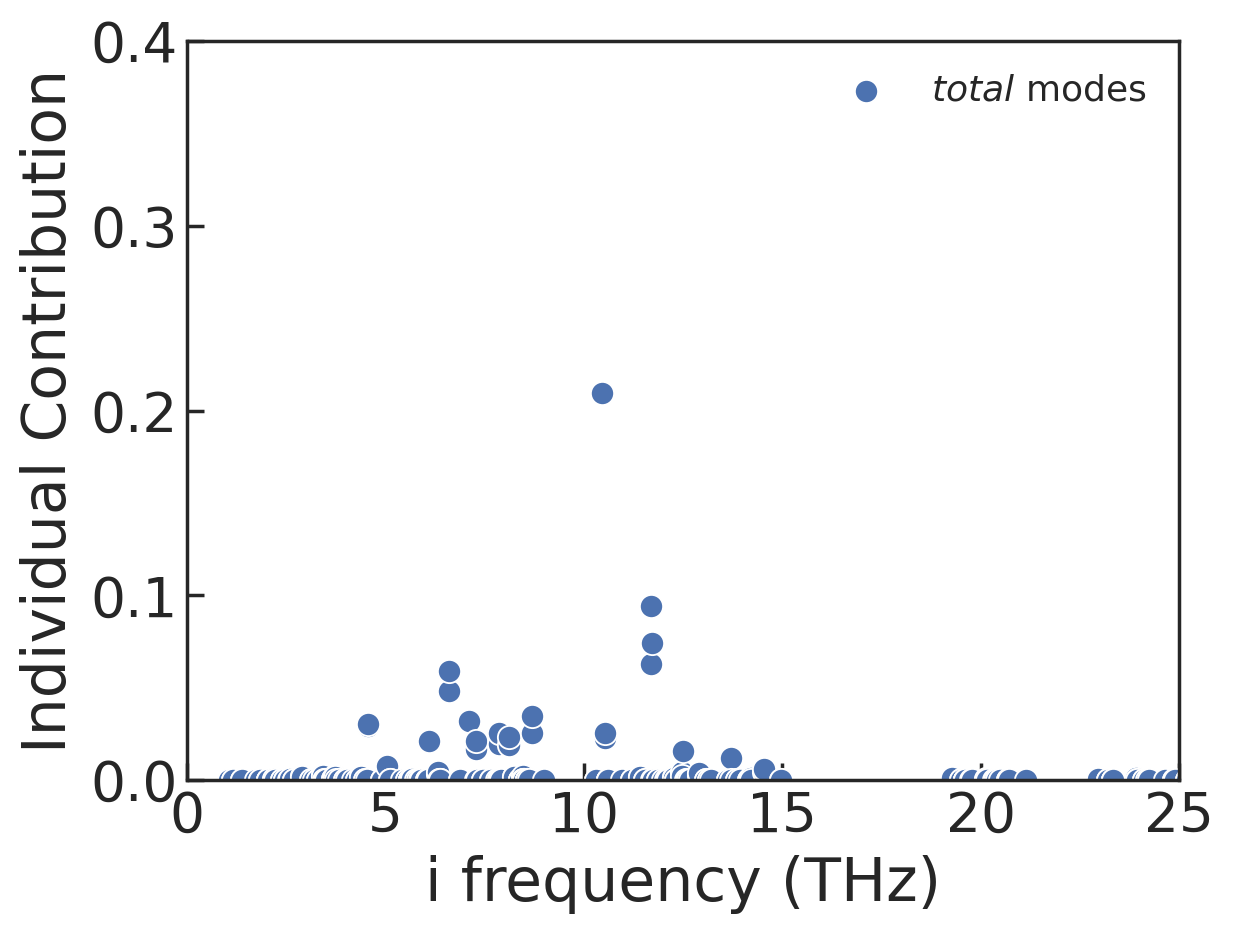

In [12]:
import seaborn as sns
list1 = ['Sc-Se']
i1 = 'O'
step = 5
temp = 900
# step = 10
df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')
print(len(df1))
df5 = df1[df1['index i']==df1['index j']]
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})

df_total_O = df_total_O.reset_index()
df_total_O1 = df_total_O.sort_values(by=['i frequency (THz)'],ascending=True)

df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)
# Oe_dict = Oe_dict1[list1[0]]
# Oc_dict = Oc_dict1[list1[0]]
# On_dict = On_dict1[list1[0]]#[237,236,235,234,232,228,222,221,213,211,209,193,192,190,185,179,178,176,172,163,162,156,184,150,139,123,122,120,113,99,98,97,90,88,84,82,78,70,68,66,51,44,41,39,38,34,33,22,18,10,9,8,6,5,4,3,2]
# df_total_Oe_1 =df_total_O1[df_total_O1['index i'].isin(Oe_dict)]
# df_total_Oc_1 =df_total_O1[df_total_O1['index i'].isin(Oc_dict)]
# df_total_On_1 =df_total_O1[df_total_O1['index i'].isin(On_dict)]
sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})

# plt.minorticks_on()
plt.tick_params(direction='in')
# df7.loc[np.abs(df7['Contribution D $_{\sigma}$'])<-0.00000001,'Contribution D $_{\sigma}$'] = None
df8 = df7.loc[(df7['Contribution D $_{\sigma}$']!=0)]
# df9 = df7[df7['index i'].isin(Oe_dict)]
# df10 = df7[df7['index i'].isin(Oc_dict)]

g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_O1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="b",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_Oc_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#e377c2",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_On_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#7f7f7f",s=70)#, height=7)

g.set_ylabel('Individual Contribution')
g.set_xlim(0,25)
g.set_ylim(0,0.40)
plt.legend(labels = [ r'$total$ modes', ],fontsize=13,frameon=False) # r'$O_c$ modes','$O_n$ modes'
fig = g.get_figure()

#
# fig.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/Li3MSH/Li3{list1[0]}(SH)/phonon/{temp}k_norm_anharmonic_D1_total_{step}.png") 

In [67]:
df_total_O1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=True)

,i frequency (THz),index i,Contribution D $_{\sigma}$
155,14.275151,158,-0.001319
166,14.744786,169,-0.000780
89,8.778955,92,-0.000258
33,4.143275,36,-0.000240
199,20.734452,202,-0.000053
...,...,...,...
98,9.374764,101,0.057496
72,6.996780,75,0.063493
134,12.863649,137,0.099360
162,14.571088,165,0.115547


56169


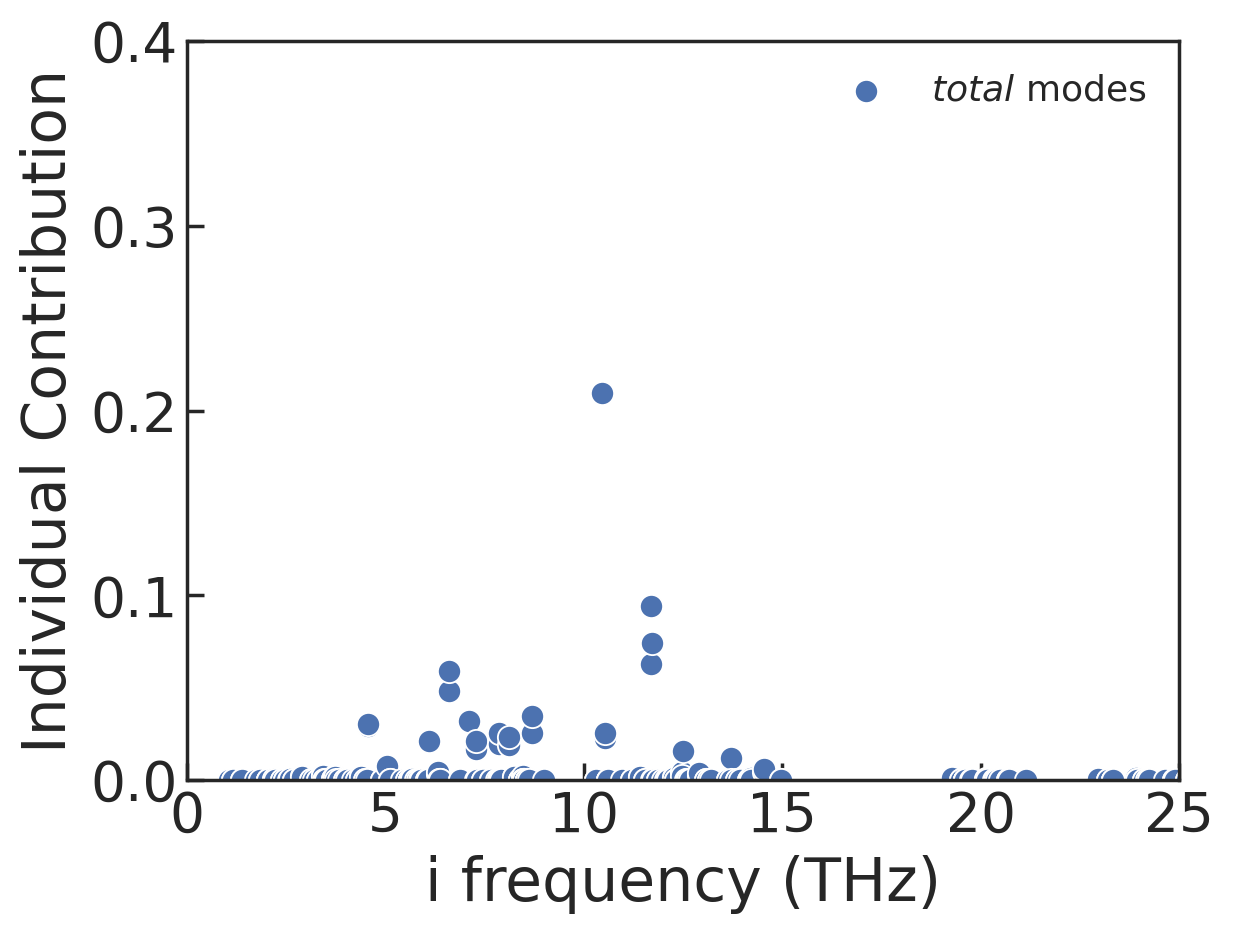

In [290]:
import seaborn as sns
# list1 = ['Al-Se']
i1 = 'O'
# step = 1
# temp = 300
step = 5
df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')
print(len(df1))
df5 = df1[df1['index i']==df1['index j']]
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})

df_total_O = df_total_O.reset_index()
df_total_O1 = df_total_O.sort_values(by=['i frequency (THz)'],ascending=True)

df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)
# Oe_dict = Oe_dict1[list1[0]]
# Oc_dict = Oc_dict1[list1[0]]
# On_dict = On_dict1[list1[0]]#[237,236,235,234,232,228,222,221,213,211,209,193,192,190,185,179,178,176,172,163,162,156,184,150,139,123,122,120,113,99,98,97,90,88,84,82,78,70,68,66,51,44,41,39,38,34,33,22,18,10,9,8,6,5,4,3,2]
# df_total_Oe_1 =df_total_O1[df_total_O1['index i'].isin(Oe_dict)]
# df_total_Oc_1 =df_total_O1[df_total_O1['index i'].isin(Oc_dict)]
# df_total_On_1 =df_total_O1[df_total_O1['index i'].isin(On_dict)]
sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})

# plt.minorticks_on()
plt.tick_params(direction='in')
# df7.loc[np.abs(df7['Contribution D $_{\sigma}$'])<-0.00000001,'Contribution D $_{\sigma}$'] = None
df8 = df7.loc[(df7['Contribution D $_{\sigma}$']!=0)]
# df9 = df7[df7['index i'].isin(Oe_dict)]
# df10 = df7[df7['index i'].isin(Oc_dict)]

g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_O1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="b",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_Oc_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#e377c2",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_On_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#7f7f7f",s=70)#, height=7)

g.set_ylabel('Individual Contribution')
g.set_xlim(0,25)
g.set_ylim(0,0.40)
plt.legend(labels = [ r'$total$ modes', ],fontsize=13,frameon=False) # r'$O_c$ modes','$O_n$ modes'
fig = g.get_figure()

#
# fig.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/Li3MSH/Li3{list1[0]}(SH)/phonon/{temp}k_norm_anharmonic_D1_total_{step}.png") 

In [17]:
df_total_O1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=True)

,i frequency (THz),index i,Contribution D $_{\sigma}$
136,12.962440,139,-0.013118
69,6.864738,72,-0.002491
61,6.336966,64,-0.002185
127,12.315100,130,-0.001878
154,14.195238,157,-0.001737
...,...,...,...
71,7.021159,74,0.060152
133,12.875021,136,0.070867
73,7.043582,76,0.090476
144,13.610666,147,0.102521


In [258]:
df_total_O1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=True)

,i frequency (THz),index i,Contribution D $_{\sigma}$
69,5.676909,72,-3.887949e-04
98,7.812455,101,-6.785940e-05
212,20.705240,215,-6.705049e-06
211,20.705239,214,-1.694394e-06
161,12.588083,164,-1.058055e-08
...,...,...,...
84,6.605113,87,6.415905e-02
85,6.605113,88,6.610873e-02
140,11.683375,143,7.861145e-02
141,11.683378,144,8.170420e-02


In [259]:
df_total_O1['res'] = df_total_O1['i frequency (THz)']*df_total_O1['Contribution D $_{\sigma}$']
c = df_total_O1['res'].mean()/df_total_O1['Contribution D $_{\sigma}$'].mean()

In [260]:
c

8.92437923611804

In [177]:
'Ga-Se':10.972386029833231
'In-Se':10.804986416912971
'Al-Se':10.669777596611924
'Sc-Se':9.340498652796157
'Y-Se':9.54214922065965
'La-Se':9.492946826016592

SyntaxError: illegal target for annotation (834385877.py, line 1)

In [154]:
df_total_O

,i frequency (THz),index i,Contribution D $_{\sigma}$
0,1.277076,3,1.919881e-18
1,1.333886,4,2.250596e-04
2,1.464541,5,-5.712063e-19
3,1.680091,6,3.381765e-05
4,1.874886,7,6.800514e-19
...,...,...,...
232,23.966419,235,1.185202e-06
233,23.989843,236,1.280795e-06
234,24.038058,237,-2.527732e-20
235,24.055759,238,-5.902465e-20


In [217]:
np.sum(df1[df1['index i']==df1['index j']]['Contribution D $_{\sigma}$'])

0.5303218222960309

In [111]:
Oe_dict1 = {'Al-Se':[240-i for i in [10,27,56,62,70,78,80,83,92,93,96,97,99,102,110,111,112,113,120,121,122,123,134,138,141,142,144,145,146,147,148,150,151,154,156,157,159,160,161,163,164,165,166,167,168,170,174,182,188,192,193,194,195,196,197,200,203,207,210,211,214,216,218,219,220,221,222,223,228,231,232,235]],
           'Ga-Se':[240-i for i in [9,10,11,24,29,30,31,32,34,35,39,40,41,45,48,52,54,55,58,60,38,42,49,50,59,73,81,84,95,96,112,113,114,115,116,120,122,123,124,125,127,144,145,146,147,148,149,150,151,152,153,154,156,157,158,166,177,178,185,192,193,194,195,200,201,202,205,210,217,218,221,222,223]],
           'In-Se':[240-i for i in [27,28,29,30,38,39,44,46,47,50,51,52,53,55,60,61,62,63,65,70,71,72,73,75,76,82,84,96,102,103,106,111,112,113,114,118,120,121,137,144,145,146,147,148,149,150,151,153,154,155,159,160,163,164,166,170,171,175,176,185,186,187,193,194,195,200,201,202,205,212,215,218,219,220,221,222,223]],
           'Sc-Se':[240-i for i in [4,5,9,10,27,28,32,33,34,36,37,46,47,49,51,52,58,59,63,66,67,68,69,73,87,91,107,112,117,142,144,145,146,147,148,149,151,152,154,155,156,158,160,161,162,166,167,168,169,170,173,176,177,179,180,181,186,200,203,204,210,212,213,219,220,221,70,71,72,88,93,94,95,96,97,98,99,100,101,102,123, 124, 130, 138,108,109,111,113,103]],
           'Y-Se':[240-i for i in [1,2,29,30,31,32,33,34,36,37,40,46,47,48,49,50,51,52,55,56,57,65,68,69,79,84,87,88,89,90,91,92,93,94,95,104,105,106,121,127,145,146,147,155,158,159,160,161,162,163,164,165,166,169,170,171,172,178,181,185,186,193,194,195,196,197,198,199,205,212,213,214,215,216,219,220,221,222,223]],
           'La-Se':[240-i for i in [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,19,20,21,22,23,24,27,29,30,31,32,33,34,35,37,38,39,42,43,46,47,49,50,55,56,61,62,63,65,69,71,72,74,79,80,84,85,86,87,89,93,95,99,104,105,107,108,109,111,123,127,181]]}


In [112]:
Oc_dict1={'La-Se':[240-i for i in [17,28,51,52,53,54,58,59,60,66,73,75,88,90,91,92,94,96,97,98,100,101,102,103,117,118,119,120,121,122,124,125,131,132,135,136,137,138,139,141,144,145,147,150,151,152,154,155,156,157,158,162,164,165,166,169,170,172,173,174,175,176,178,179,182,183,184,185,186,188,189,190,191,192,193,194,195,196,197,198,199,200,202,203,204,205,206,207,213,215,217,218,220,221,222,223,226,227,233,234,235,236]]
    ,'Y-Se':[240-i for i in [4,5,6,7,8,21,23,24,35,38,39,43,53,54,63,66,67,70,77,78,96,97,98,99,100,101,103,107,108,111,112,113,116,117,118,119,120,122,123,124,125,126,136,137,138,141,142,148,156,173,174,175,176,177,179,180,182,183,184,187,188,189,190,191,192,200,201,202,203,204,206,207,208,209,210,211,217,218]]
    ,'In-Se':[240-i for i in[1,2,4,5,6,7,8,17,36,37,40,41,45,54,56,57,68,69,83,91,97,98,99,100,101,104,105,107,108,109,110,115,116,117,119,122,123,124,125,126,127,169,172,173,174,177,178,179,180,181,182,183,184,188,189,190,191,192,196,197,198,199,203,204,206,207,208,209,210,211,213,214,217] ]
    ,'Ga-Se':[240-i for i in [1,3,4,6,7,8,14,33,61,62,63,64,67,68,69,76,80,91,99,100,101,102,103,104,105,107,108,109,110,111,117,118,119,121,126,129,132,137,139,160,163,167,168,169,170,171,172,173,174,175,176,179,180,181,182,183,184,186,187,188,189,190,191,196,197,198,199,203,204,206,207,208,209,211,212,213,214,219,220]],
    'Al-Se':[241-i for i in [4,5,6,7,11,17,25,29,36,37,38,40,47,49,61,63,64,65,71,72,73,74,75,76,89,94,95,98,100,101,106,107,109,114,115,117,118,119,124,125,133,135,136,139,140,149,155,162,171,172,173,175,176,177,178,179,180,181,184,185,186,187,189,190,191,199,201,202,204,205,206,208,209,212,217,226]],
    'Sc-Se':[240-i for i in [53,54,56,57,118,119,136,0,1,2,6,7,8,22,23,24,30,31,35,38,39,42,43,48,178,182,183,184,185,187,188,189,190,191,192,193,194,195,196,197,198,199,201,202,206,207,208,217,218,222,223,61, 62, 63, 64, 65, 74, 75, 76, 77, 78, 79,80, 81, 82, 83, 84, 85, 86, 89,121,122,125,126,127,44,45,115,116,128,129,131,163,164,165,209,134,141]]}

In [113]:
On_dict1 = {'La-Se':[240-i for i in [3,18,25,26,36,40,41,44,45,48,57,64,67,68,70,76,77,78,81,82,83,106,110,112,113,114,115,116,126,128,129,130,133,134,140,142,143,146,148,149,153,159,160,161,163,167,168,171,177,180,187,201,208,209,210,211,212,214,216,219,224,225,228,229,230,231,232,237,238,239]]
    ,'Y-Se':[240-i for i in [0,3,9,10,11,12,13,14,15,16,17,18,19,20,22,25,26,27,28,41,42,44,45,58,59,60,61,62,64,71,72,73,74,75,76,80,81,82,83,85,86,102,109,110,114,115,120,128,129,130,131,132,133,134,135,139,140,143,144,149,150,151,152,153,154,157,167,168,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239]]
    ,'In-Se':[240-i for i in [0,3,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,31,32,33,34,35,42,43,48,49,58,59,64,66,67,74,77,78,79,80,81,85,86,87,88,89,90,92,93,94,95,128,129,130,131,132,133,134,135,136,138,139,140,141,142,143,152,156,157,158,161,162,165,167,168,216,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239]]
   ,'Ga-Se':[240-i for i in [0,2,5,12,13,15,16,17,18,19,20,21,22,23,25,26,27,28,36,37,43,44,46,47,51,53,56,57,65,66,70,71,72,74,75,77,78,79,82,83,85,86,87,88,89,90,92,93,94,97,98,106,128,130,131,133,134,135,136,138,140,141,142,143,155,159,161,162,164,165,215,216,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239]],
    'Al-Se':[241-i for i in [0,1,2,3,12,13,14,15,16,18,19,22,23,24,26,35,39,42,43,44,45,46,48,53,54,55,57,58,59,60,66,67,68,77,78,79,80,81,82,83,84,85,86,87,88,90,91,102,103,104,105,108,116,126,127,128,129,130,131,132,137,143,152,153,158,159,169,183,213,215,216,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239]],
    'Sc-Se':[240-i for i in [137,138,139,140,143,150,171,172,174,175,3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 29, 30, 40, 41, 47, 50, 52, 54, 55, 60, 143, 152, 153, 159, 205, 207, 210, 211, 214, 215, 216, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,100, 101, 102, 104, 110, 119, 120,90, 92, 99,104,105,106,114,132,133,135,157]]}

In [114]:
a = [137,138,139,140,143,150,171,172,174,175,3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 29, 30, 40, 41, 47, 50, 52, 54, 55, 60, 143, 152, 153, 159, 205, 207, 210, 211, 214, 215, 216, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,100, 101, 102, 104, 110, 119, 120,90, 92, 99,104,105,106,114]
b = [53,54,56,57,118,119,136,0,1,2,6,7,8,22,23,24,30,31,35,38,39,42,43,48,178,182,183,184,185,187,188,189,190,191,192,193,194,195,196,197,198,199,201,202,206,207,208,217,218,222,223,61, 62, 63, 64, 65, 74, 75, 76, 77, 78, 79,80, 81, 82, 83, 84, 85, 86, 89,121,122,125,126,127]
c = [4,5,9,10,27,28,32,33,34,36,37,46,47,49,51,52,58,59,63,66,67,68,69,73,87,91,107,112,117,142,144,145,146,147,148,149,151,152,154,155,156,158,160,161,162,166,167,168,169,170,173,176,177,179,180,181,186,200,203,204,210,212,213,219,220,221,70,71,72,88,93,94,95,96,97,98,99,100,101,102,123, 124, 130, 138,108,109,111,113,103]

In [115]:
d =a+b+c

In [116]:
for i in range(0,240):
    if i in d:
        pass
    else:
        print(i)

44
45
115
116
128
129
131
132
133
134
135
141
157
163
164
165
209


56169


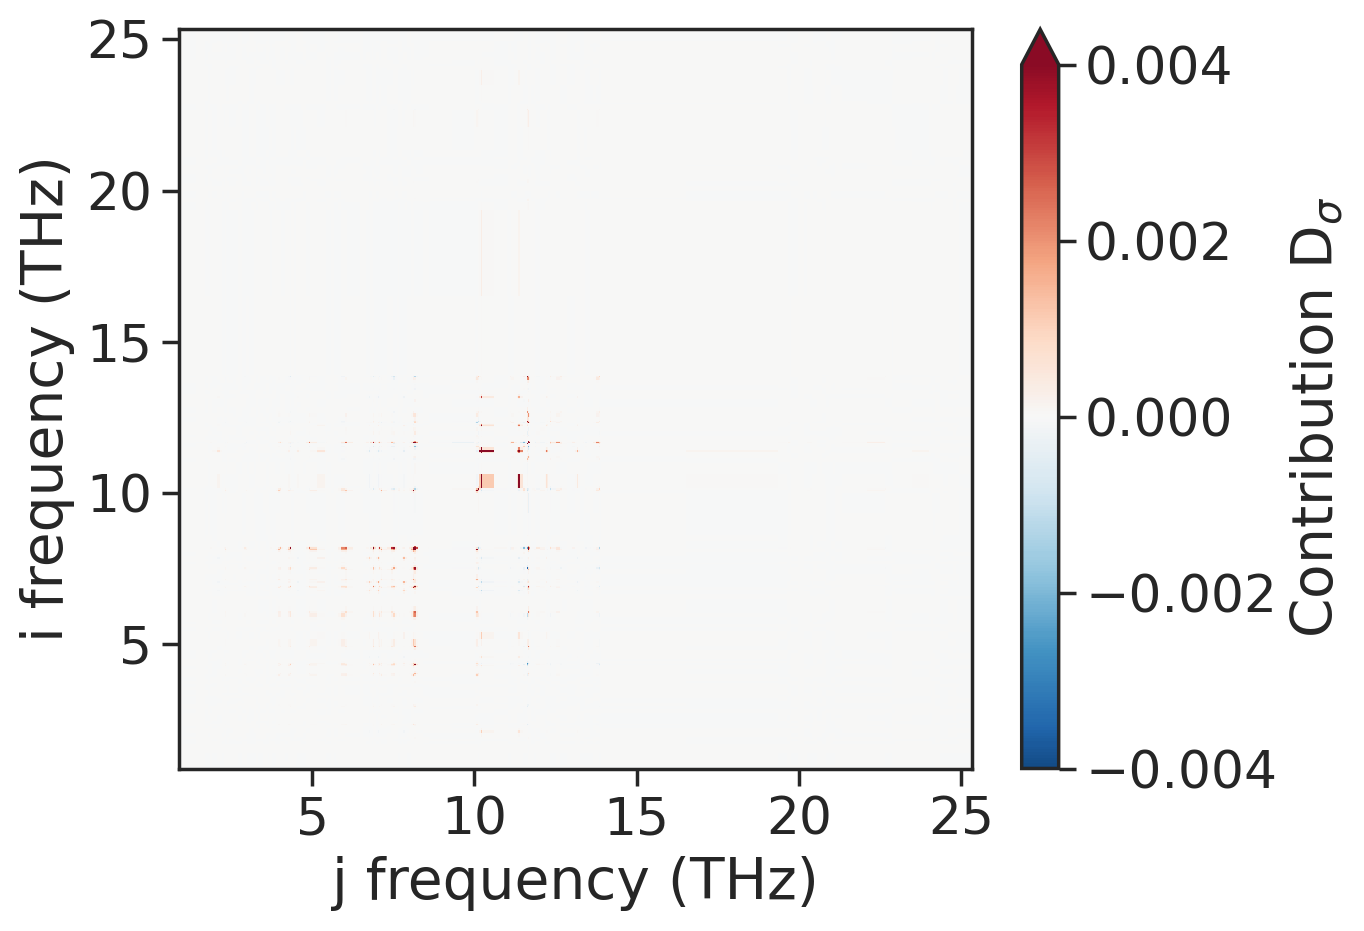

In [357]:
# df = pd.DataFrame(pd_res)
import seaborn as sns
sns.set(font_scale=1.7,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
list1 = ['Y-Se']
# temp = 300
step =5
df = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')
df = df[(df['i frequency (THz)']>0)&(df['j frequency (THz)']>0)]#&(df['i frequency (THz)']<25)&(df['j frequency (THz)']<25)]
df1 = copy.deepcopy(df)
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])

df3 = copy.deepcopy(df1)
print(len(df3))
# df3.loc[df3['Contribution D $_{\sigma}$'],'Contribution D $_{\sigma}$']=0
df4 = df3['Contribution D $_{\sigma}$'].values.reshape(int(np.sqrt(len(df3))),int(np.sqrt(len(df3))))
from scipy.ndimage import gaussian_filter
data2 = gaussian_filter(df4, sigma=0.5)
xr1 = xr.DataArray(data=data2,coords={'i frequency (THz)':np.unique(df1['i frequency (THz)']),'j frequency (THz)':np.unique(df1['j frequency (THz)'])},dims=['i frequency (THz)','j frequency (THz)'])
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=4/8,stop=0.95)
# df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/NaM_IO3_2/{list1[0]}/phonon/900k_norm_anharmonic_D1_total1.csv')
# cbar.set_label('Contribution D$_{\sigma}$',rotation=90,)
# xr1.plot.scatter(x='i frequency (THz)',y='j frequency (THz)',vmin=-0.004,vmax=0.004,cmap=cm1,cbar_kwargs={'label':'Contribution D$_{\sigma}$'},markersize=10)

xr1.plot.pcolormesh(vmin=-0.004,vmax=0.004,center=0,cmap=cm1,cbar_kwargs={'label':'Contribution D$_{\sigma}$'},infer_intervals=False)#interpolation='Gaussian',xscale='linear',xticks=[0,5,10,15,20,25],yticks=[0,5,10,15,20,25])
# plt.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/heatmap_{temp}k_norm_anharmonic_D1_total1.png") 

In [313]:
# data2

array([[ 0.00000001,  0.00000001,  0.00000001, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.00000001,  0.00000001,  0.00000001, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.00000001,  0.00000001,  0.00000001, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [18]:
df1[df1['index i'] == df1['index j']]['i frequency (THz)']

0         0.597778
238       0.655757
476       0.690003
714       0.695733
952       0.852328
           ...    
55216    24.265035
55454    24.267068
55692    24.605977
55930    24.608967
56168    24.773047
Name: i frequency (THz), Length: 237, dtype: float64

In [16]:
df1[df1.isin(np.unique(df1['index i']))]

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
0,False,True,True,False,False,False
1,False,True,True,False,False,False
2,False,True,True,False,False,False
3,False,True,True,False,False,False
4,False,True,True,False,False,False
...,...,...,...,...,...,...
56164,False,True,True,False,False,False
56165,False,True,True,False,False,False
56166,False,True,True,False,False,False
56167,False,True,True,False,False,False


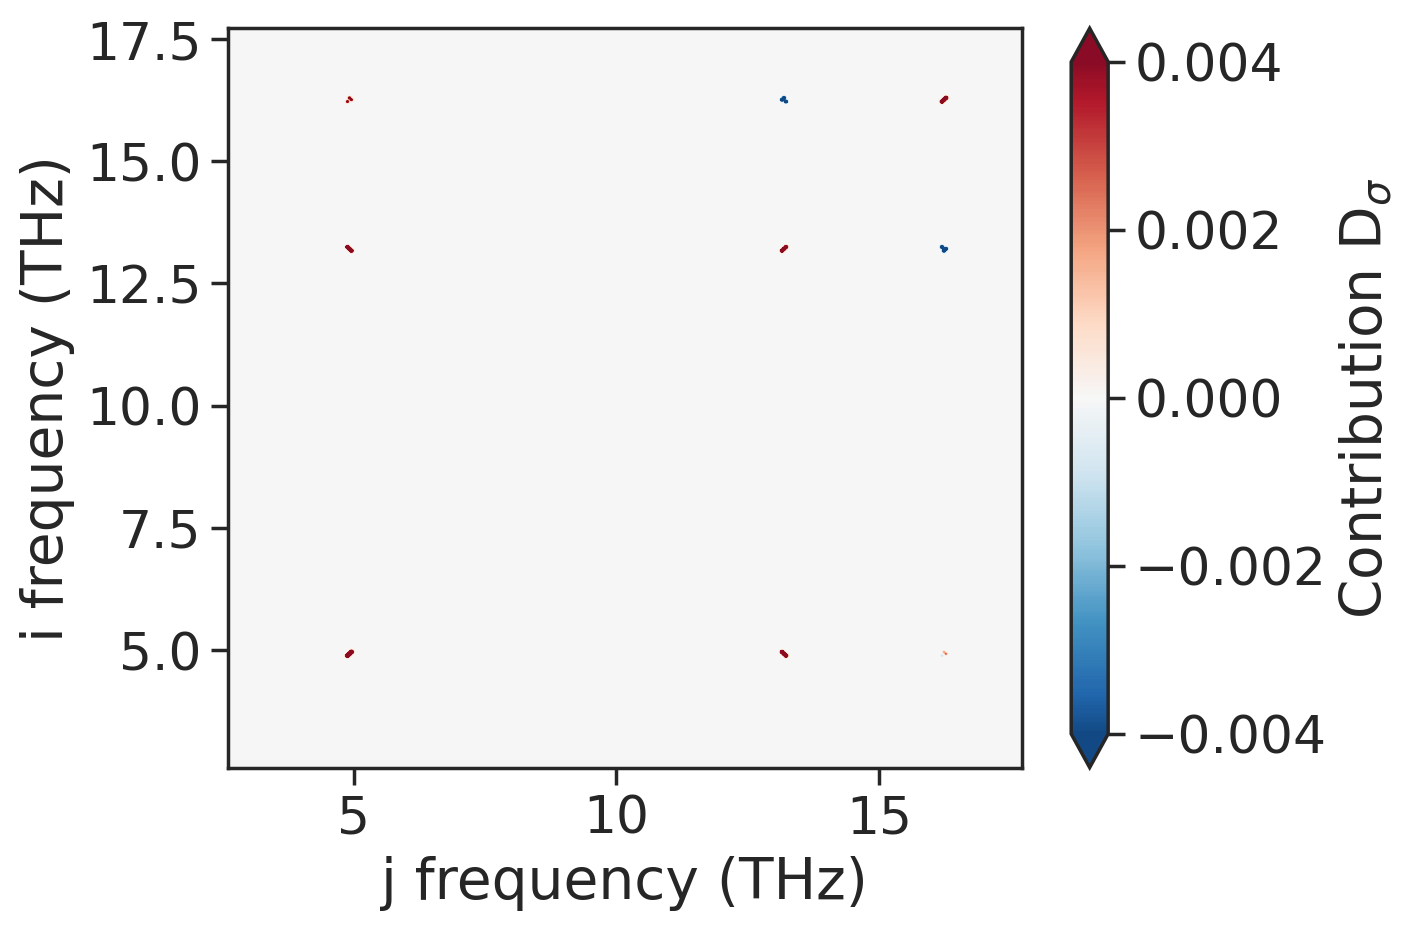

In [225]:
# df = pd.DataFrame(pd_res)
import seaborn as sns
sns.set(font_scale=1.7,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
# list1 = ['Br']
i1 = 'O'
temp = 800
step = 5
df = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/Li3MSH/Li3{i1}Cl/phonon/{temp}k_norm_anharmonic_D1_total_{step}.csv')
df = df[(df['i frequency (THz)']>0)&(df['j frequency (THz)']>0)&(df['i frequency (THz)']<50)&(df['j frequency (THz)']<50)]#&(df['i frequency (THz)']<25)&(df['j frequency (THz)']<25)]
df1 = copy.deepcopy(df)
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])

df3 = copy.deepcopy(df1)
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})
df_total_O1 = df_total_O.sort_values(by=['Contribution D $_{\sigma}$'],ascending=True)
# print(len(df3))
# df3.loc[df3['Contribution D $_{\sigma}$'],'Contribution D $_{\sigma}$']=0
df4 = df3['Contribution D $_{\sigma}$'].values.reshape(int(np.sqrt(len(df3))),int(np.sqrt(len(df3))))
xr1 = xr.DataArray(data=df4,coords={'i frequency (THz)':df3.drop_duplicates(subset=['index i'])['i frequency (THz)'].tolist(),'j frequency (THz)':df3.drop_duplicates(subset=['index j'])['j frequency (THz)'].tolist()},dims=['i frequency (THz)','j frequency (THz)'])
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=4/8,stop=0.95)
# print(df3.drop_duplicates(subset=['index i'])['i frequency (THz)'].tolist())
# df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/NaM_IO3_2/{list1[0]}/phonon/900k_norm_anharmonic_D1_total1.csv')
# cbar.set_label('Contribution D$_{\sigma}$',rotation=90,)
# xr1.plot(x='j frequency (THz)',y='i frequency (THz)',vmin=-0.004,vmax=0.004,cmap=cm1,cbar_kwargs={'label':'Contribution D$_{\sigma}$'})
# ax.set_xlim(0,20)
# ax.set_ylim(0,20)
xr1.plot.imshow(vmin=-0.004,vmax=0.004,center=0,cmap=cm1,cbar_kwargs={'label':'Contribution D$_{\sigma}$'},interpolation='Gaussian') #
# plt.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/heatmap_{temp}k_norm_anharmonic_D1_total1.png") 

In [226]:
df_total_O1[-6:-1][df_total_O1.keys()]#['i frequency (THz)']

Contribution D $_{\sigma}$
i frequency (THz) index i                            
11.063517         285                        0.071864
                  283                        0.075098
                  284                        0.076115
3.365393          63                         0.196752
                  65                         0.203299

In [183]:
# df3.drop_duplicates(subset=['index i'])['i frequency (THz)'].tolist()

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
8239,9259,64,43,6.245209,4.338957,0.018412
14802,16057,111,73,11.817234,7.466264,0.018545
3141,3976,27,88,3.427514,8.795358,0.019147
5341,6256,43,64,4.338957,6.245209,0.022632
14107,15337,106,73,11.537017,7.466264,0.023277
11598,12738,88,66,8.795358,6.485783,0.033427
10486,11586,80,66,8.183045,6.485783,0.036187
9520,10585,73,73,7.466264,7.466264,0.039219
8540,9570,66,66,6.485783,6.485783,0.051217
8260,9280,64,64,6.245209,6.245209,0.052051


56169


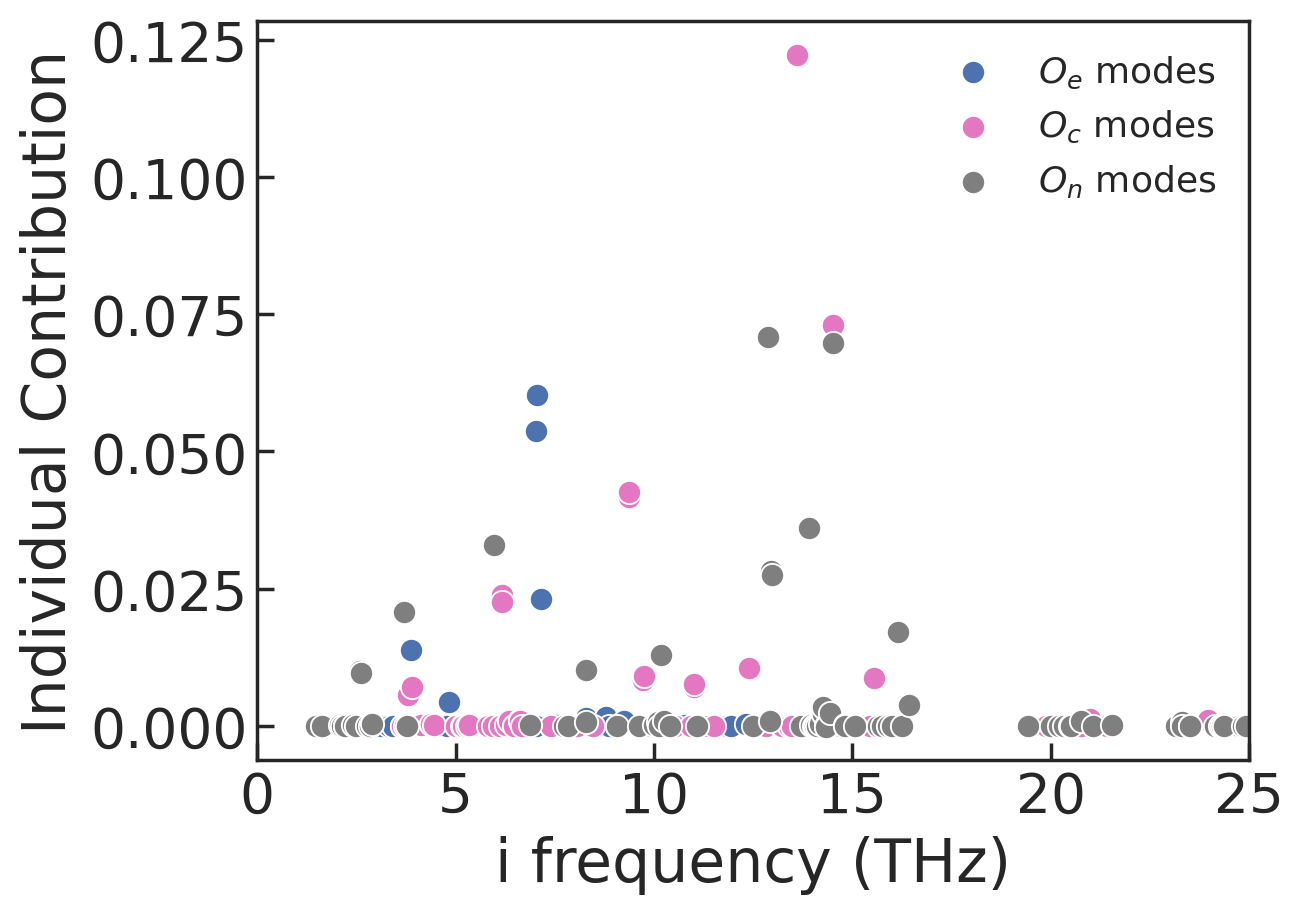

In [126]:
import seaborn as sns
list1 = ['Al-Se']
step = 5
temp = 300
df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')
print(len(df1))
df5 = df1[df1['index i']==df1['index j']]
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})

df_total_O = df_total_O.reset_index()
df_total_O1 = df_total_O.sort_values(by=['i frequency (THz)'],ascending=True)

df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)
Oe_dict = Oe_dict1[list1[0]]
Oc_dict = Oc_dict1[list1[0]]
On_dict = On_dict1[list1[0]]#[237,236,235,234,232,228,222,221,213,211,209,193,192,190,185,179,178,176,172,163,162,156,184,150,139,123,122,120,113,99,98,97,90,88,84,82,78,70,68,66,51,44,41,39,38,34,33,22,18,10,9,8,6,5,4,3,2]
df_total_Oe_1 =df_total_O1[df_total_O1['index i'].isin(Oe_dict)]
df_total_Oc_1 =df_total_O1[df_total_O1['index i'].isin(Oc_dict)]
df_total_On_1 =df_total_O1[df_total_O1['index i'].isin(On_dict)]
sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})

# plt.minorticks_on()
plt.tick_params(direction='in')
# df7.loc[np.abs(df7['Contribution D $_{\sigma}$'])<-0.00000001,'Contribution D $_{\sigma}$'] = None
df8 = df7.loc[(df7['Contribution D $_{\sigma}$']!=0)]
df9 = df7[df7['index i'].isin(Oe_dict)]
df10 = df7[df7['index i'].isin(Oc_dict)]

g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_Oe_1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="b",s=70)#, height=7)
g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_Oc_1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="#e377c2",s=70)#, height=7)
g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_On_1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="#7f7f7f",s=70)#, height=7)

g.set_ylabel('Individual Contribution')
g.set_xlim(0,25)
plt.legend(labels = [ r'$O_e$ modes', r'$O_c$ modes','$O_n$ modes'],fontsize=13,frameon=False)
fig = g.get_figure()

#
# fig.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total1.png") 

In [61]:
df_total_Oc_1['res'] = df_total_Oc_1['i frequency (THz)']*df_total_Oc_1['Contribution D $_{\sigma}$']

In [62]:
c = df_total_Oc_1['res'].mean()/df_total_Oc_1['Contribution D $_{\sigma}$'].mean()

In [63]:
c

5.66031048132083

66564


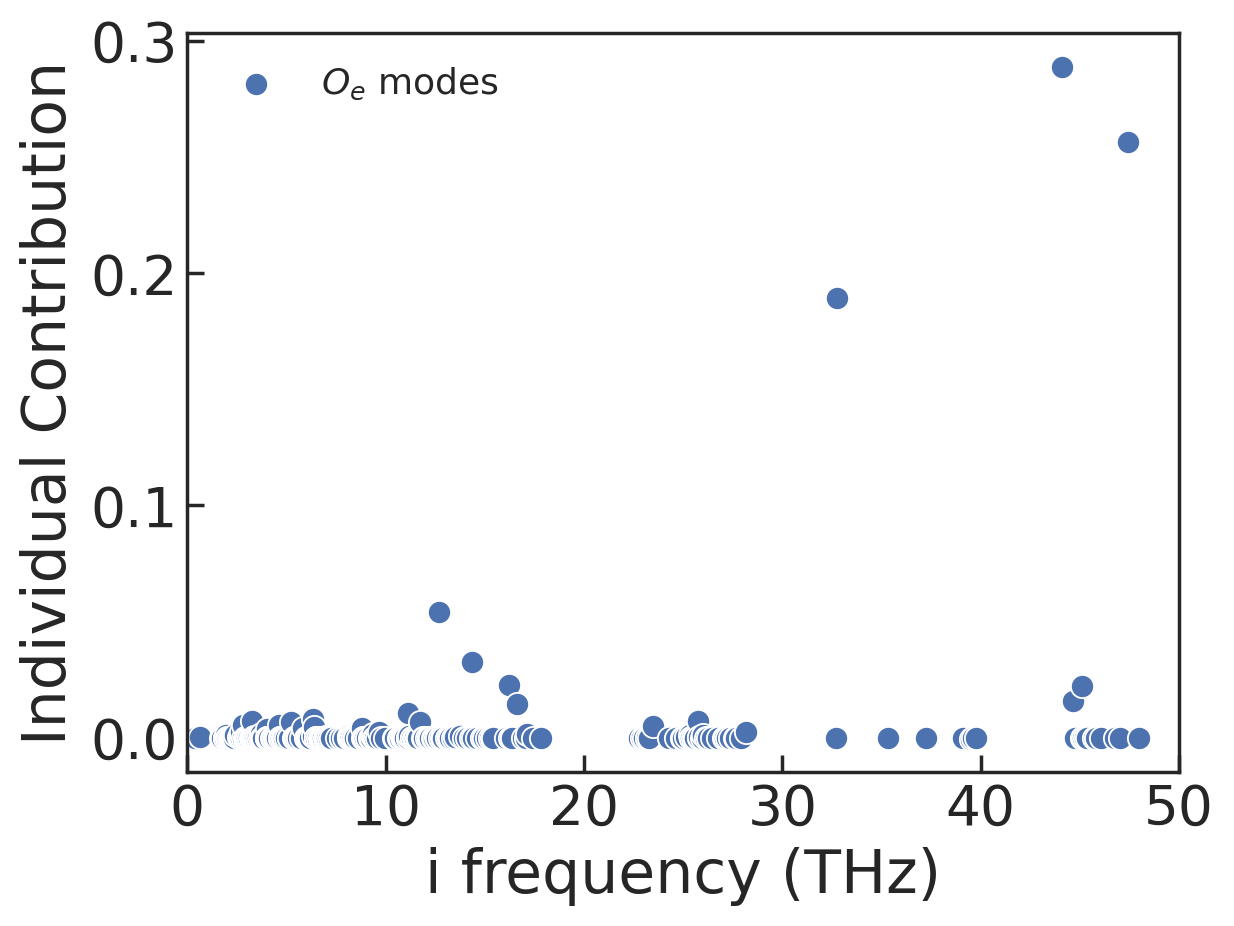

In [26]:
import seaborn as sns
list1 = ['521']
temp = 900
df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/Li_candidate/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}.csv')
print(len(df1))
df5 = df1[df1['index i']==df1['index j']]
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})

df_total_O = df_total_O.reset_index()
df_total_O1 = df_total_O.sort_values(by=['i frequency (THz)'],ascending=True)

df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)
# Oe_dict = Oe_dict1[list1[0]]
# Oc_dict = Oc_dict1[list1[0]]
# On_dict = On_dict1[list1[0]]#[237,236,235,234,232,228,222,221,213,211,209,193,192,190,185,179,178,176,172,163,162,156,184,150,139,123,122,120,113,99,98,97,90,88,84,82,78,70,68,66,51,44,41,39,38,34,33,22,18,10,9,8,6,5,4,3,2]
# df_total_Oe_1 =df_total_O1[df_total_O1['index i'].isin(Oe_dict)]
# df_total_Oc_1 =df_total_O1[df_total_O1['index i'].isin(Oc_dict)]
# df_total_On_1 =df_total_O1[df_total_O1['index i'].isin(On_dict)]
sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})

# plt.minorticks_on()
plt.tick_params(direction='in')
# df7.loc[np.abs(df7['Contribution D $_{\sigma}$'])<-0.00000001,'Contribution D $_{\sigma}$'] = None
df8 = df7.loc[(df7['Contribution D $_{\sigma}$']!=0)]
# df9 = df7[df7['index i'].isin(Oe_dict)]
# df10 = df7[df7['index i'].isin(Oc_dict)]

g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_O1,
                  # kind="reg",
                  # xlim=(0, 25), ylim=(0, 0.3),
                   color="b",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_Oc_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#e377c2",s=70)#, height=7)
# g = sns.scatterplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df_total_On_1,
#                   # kind="reg",
#                   # xlim=(0, 25), ylim=(0, 0.3),
#                    color="#7f7f7f",s=70)#, height=7)

g.set_ylabel('Individual Contribution')
g.set_xlim(0,50)
plt.legend(labels = [ r'$O_e$ modes', r'$O_c$ modes','$O_n$ modes'],fontsize=13,frameon=False)
fig = g.get_figure()

#
# fig.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total1.png") 

In [158]:
# df_total_Oc_1[]

In [24]:
df_total_O = df_total.groupby(['i frequency (THz)','index i']).agg({'Contribution D $_{\sigma}$':'sum'})
df_total_O = df_total_O.reset_index()
df_total_O1 = df_total_O.sort_values(by=['Contribution D $_{\sigma}$'],ascending=True)

In [25]:
df_total_O1[-20:-1]

,i frequency (THz),index i,Contribution D $_{\sigma}$
115,8.808871,121,0.004162
88,6.390180,94,0.004512
204,23.485112,210,0.004935
26,2.795105,32,0.005439
59,4.608683,65,0.005562
150,11.744022,156,0.006656
69,5.213272,75,0.006667
216,25.750943,222,0.007087
35,3.272589,41,0.007128
86,6.347129,92,0.007895


In [166]:
c1 = df_total_Oe_1

In [169]:
# c1[0:-1]

,i frequency (THz),index i,Contribution D $_{\sigma}$
1,1.133500,236,-1.102060e-16
2,1.133500,235,1.503628e-17
6,1.829504,231,2.175221e-16
7,1.829505,230,8.818235e-18
24,3.114583,213,-1.658419e-19
...,...,...,...
207,20.414718,30,3.174181e-18
209,20.689484,28,6.357950e-19
210,20.689485,27,-1.789579e-18
216,23.202130,21,-1.945825e-21


In [551]:
c1['i frequency (THz)'].mean()

11.664959947194912

In [505]:
df_total_O1[df_total_O1['index i']==149]

,i frequency (THz),index i,Contribution D $_{\sigma}$
88,8.290931,149,-0.000067


In [20]:
df7.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
38556,39765,165,165,14.519717,14.519717,0.317689
32368,33499,139,139,12.962454,12.962454,0.058967
43554,44826,186,186,16.147517,16.147517,0.032671
5236,6025,25,25,3.701364,3.701364,0.014446
23324,24341,101,101,9.369947,9.369947,0.008515
...,...,...,...,...,...,...
30464,31571,131,131,12.387373,12.387373,-0.003213
35224,36391,151,151,13.904576,13.904576,-0.006358
32130,33258,138,138,12.946190,12.946190,-0.019572
31654,32776,136,136,12.874947,12.874947,-0.022700


In [675]:
def angle2(v1,v2):
    x=np.array(v1)
    y=np.array(v2)

    # 分别计算两个向量的模：
    module_x=np.sqrt(x.dot(x))
    module_y=np.sqrt(y.dot(y))

    # 计算两个向量的点积
    dot_value=x.dot(y)

    # 计算夹角的cos值：
    cos_theta=dot_value/(module_x*module_y)

    # 求得夹角（弧度制）：
    angle_radian=np.arccos(cos_theta)

    # 转换为角度值：
    angle_value=angle_radian*180/np.pi
    return angle_value

In [703]:
angle2(a,c)

88.17487096080447

In [701]:
a = [-0.0370,0.0015227,0.03024]
c = [0,1,0]

In [322]:
df12

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
20934,21921,149,159,7.275602,6.102282,0.040428
18574,19531,159,149,6.102282,7.275602,0.040410
30240,31344,110,96,10.985825,12.141023,0.032654
33544,34690,96,110,12.141023,10.985825,0.032618
28524,29607,117,153,8.871005,6.731500,0.021906
...,...,...,...,...,...,...
33495,34641,96,159,12.141023,6.102282,-0.031629
20983,21970,149,110,7.275602,10.985825,-0.041510
30187,31291,110,149,10.985825,7.275602,-0.041817
20997,21984,149,96,7.275602,12.141023,-0.064377


In [124]:
np.cumsum(df13['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$'])

i frequency (THz)
0.597778     0.000443
0.655757     0.000391
0.690003     0.000386
0.695733     0.000197
0.852328     0.000154
               ...   
24.265035    0.641159
24.267068    0.641160
24.605977    0.641158
24.608967    0.641158
24.773047    0.641157
Name: Contribution D $_{\sigma}$, Length: 237, dtype: float64

In [125]:
# df13.drop(['i frequency (THz)'],axis=1)

In [126]:
df7['Contribution D $_{\sigma}$']

0        3.647277e-06
238      5.154178e-07
476      4.810174e-10
714      2.088501e-07
952      3.370817e-08
             ...     
55216    3.555306e-11
55454    6.018300e-10
55692    1.461130e-11
55930    1.777650e-14
56168    7.110757e-11
Name: Contribution D $_{\sigma}$, Length: 237, dtype: float64

In [127]:
np.cumsum(df7['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$'])

0        0.000004
238      0.000004
476      0.000004
714      0.000004
952      0.000004
           ...   
55216    0.358843
55454    0.358843
55692    0.358843
55930    0.358843
56168    0.358843
Name: Contribution D $_{\sigma}$, Length: 237, dtype: float64

In [226]:
df_total

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
17136,18075,165,165,6.996780,6.996780,0.058836
12614,13496,184,184,5.992783,5.992783,0.039648
23298,24315,139,165,9.374764,6.996780,0.029734
17162,18101,165,139,6.996780,9.374764,0.027665
13581,14475,180,165,6.179792,6.996780,0.024753
...,...,...,...,...,...,...
35129,36296,89,184,13.913994,5.992783,-0.015002
12695,13577,184,103,5.992783,12.863649,-0.018322
31811,32936,103,184,12.863649,5.992783,-0.021196
12706,13588,184,92,5.992783,13.636687,-0.025031


In [213]:
df_total_Oc = df_total.groupby(['index i','i frequency (THz)']).aggregate({'Contribution D $_{\sigma}$':'sum'})
df_total_Oc1 = df_total_Oc.reset_index()
df_total_Oc1 = df_total_Oc1.sort_values(by=['i frequency (THz)'],ascending=False)
df_total_Oc2 =df_total_Oc1[df_total_Oc1['index i'].isin(Oe_dict)]

In [214]:
df_total_Oc1

,index i,i frequency (THz),Contribution D $_{\sigma}$
0,1,24.907745,-1.173554e-11
1,2,24.811744,-2.343310e-18
2,3,24.811743,2.554843e-19
3,4,24.745688,-1.402128e-06
4,5,24.745688,-2.697355e-05
...,...,...,...
232,233,1.766658,-1.913475e-16
233,234,1.766658,-1.083758e-17
234,235,1.502275,-2.999059e-16
235,236,1.502274,-8.656469e-18


In [224]:
df14["i frequency (THz)"]

0       1.473702
1       1.502274
2       1.502275
3       1.766658
4       1.766658
         ...    
232    24.745688
233    24.745688
234    24.811743
235    24.811744
236    24.907745
Name: i frequency (THz), Length: 237, dtype: float64

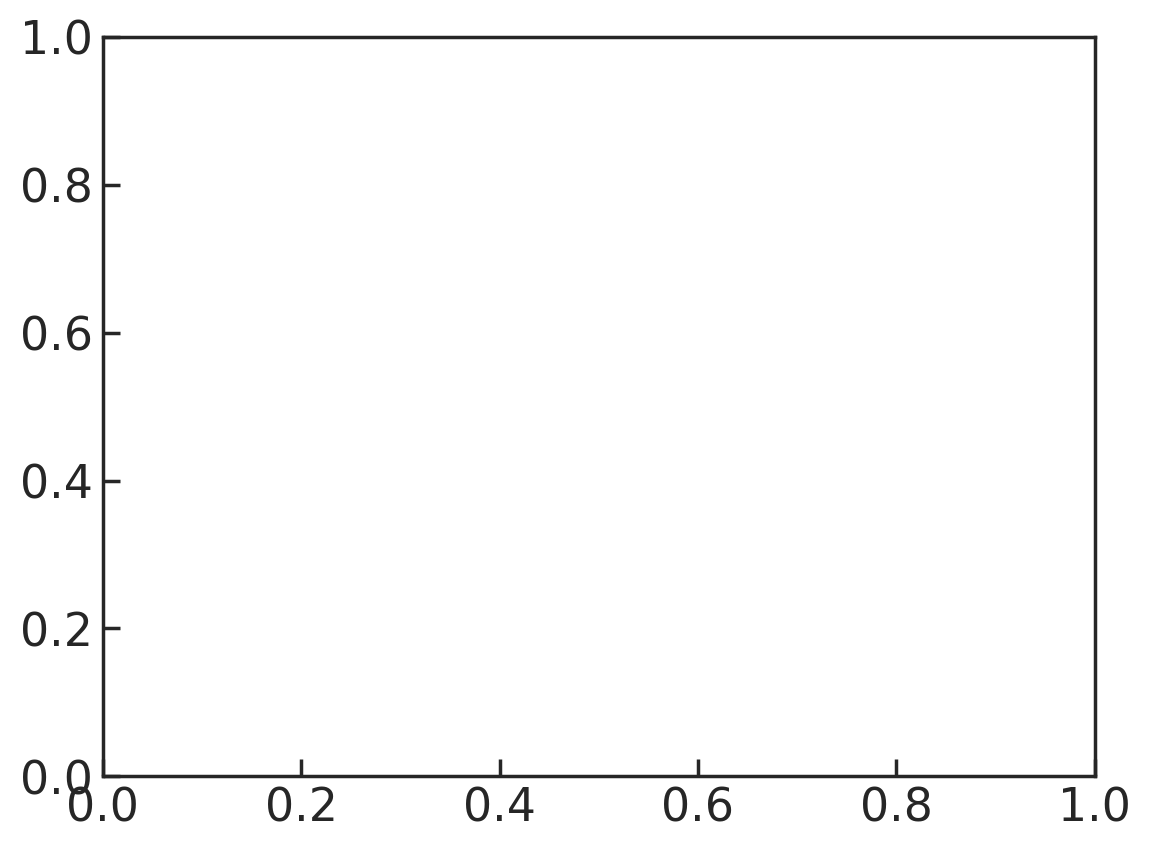

In [223]:
df11 = df1
df12 = df11.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df13 = df12.groupby(['i frequency (THz)']).agg({'Contribution D $_{\sigma}$':'sum'})
df14 = df13.reset_index()
sns.set(font_scale=1.5,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
plt.tick_params(direction='in')
# g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df_total1['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color='y',s=70)
# g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df13['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color='c',s=70)
# g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df7['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='g',s=70)
# sns.ecdfplot(data=df9, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='r')
# g = sns.scatterplot( x=df9["i frequency (THz)"],y=np.cumsum(df9['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='r',s=70)
# g = sns.scatterplot( x=df10["i frequency (THz)"],y=np.cumsum(df10['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='b',s=70)
g = sns.scatterplot( x=df14["i frequency (THz)"],y=np.cumsum(df13['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='r',s=70)

In [237]:
df_total2

,Contribution D $_{\sigma}$
index i,
1,-1.173554e-11
2,-2.343310e-18
3,2.554843e-19
4,-1.402128e-06
5,-2.697355e-05
...,...
233,-1.913475e-16
234,-1.083758e-17
235,-2.999059e-16


In [28]:
On_dict

NameError: name 'On_dict' is not defined

56169


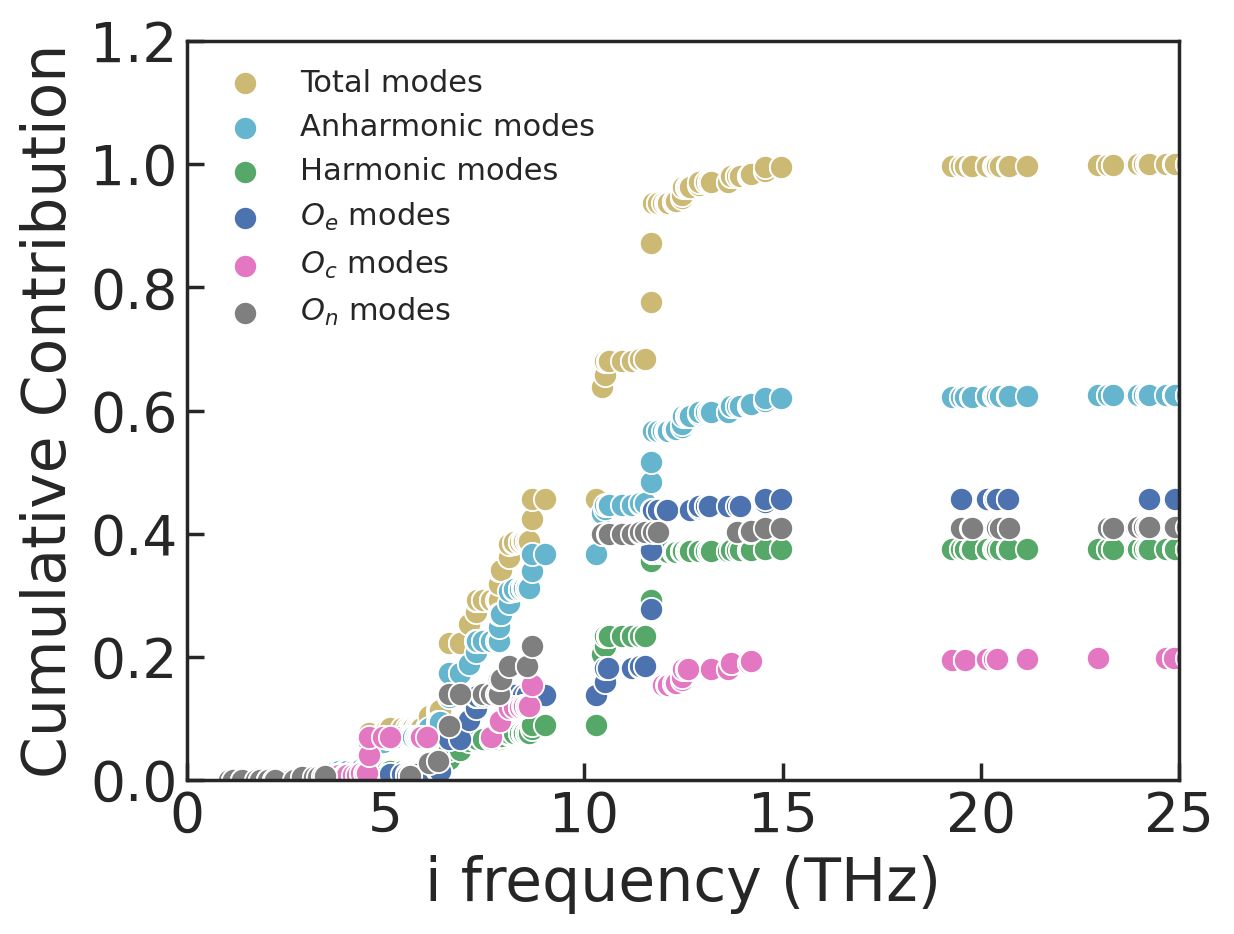

In [123]:
list1=['Sc-Se']
temp = 300
df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')

# df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/Al-Se/phonon/{temp}k_norm_anharmonic_D1_total_{step}_50000.csv')
print(len(df1))
df5 = df1[df1['index i']==df1['index j']]
df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)
df11 = df1[df1['index i']!=df1['index j']]
df12 = df11.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df13 = df12.groupby(['i frequency (THz)']).agg({'Contribution D $_{\sigma}$':'sum'})
df_total = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df_total1 = df_total.groupby(['i frequency (THz)']).agg({'Contribution D $_{\sigma}$':'sum'})
df_total2 = df_total.groupby(['index i']).agg({'Contribution D $_{\sigma}$':'sum'})
Oe_dict = Oe_dict1[list1[0]]
Oc_dict = Oc_dict1[list1[0]]#[237,236,235,234,232,228,222,221,213,211,209,193,192,190,185,179,178,176,172,163,162,156,155,184,150,139,123,122,120,113,99,98,97,90,88,84,82,78,70,68,66,51,44,41,39,38,34,33,22,18,10,9,8,6,5,4,3,2]
On_dict = On_dict1[list1[0]]
df8 = df7.loc[(df7['Contribution D $_{\sigma}$']!=0)]
df9 = df8[df8['index i'].isin(Oe_dict)]
df10 = df7[df7['index i'].isin(Oc_dict)]

df_total_Oe = df_total.groupby(['index i','i frequency (THz)']).aggregate({'Contribution D $_{\sigma}$':'sum'})
df_total_Oe1 = df_total_Oe.reset_index()
df_total_Oe1 = df_total_Oe1.sort_values(by=['i frequency (THz)'],ascending=True)
df_total_Oe2 =df_total_Oe1[df_total_Oe1['index i'].isin(Oe_dict)]
df_total_Oe2 = df_total_Oe2.sort_values(by=['i frequency (THz)'],ascending=True)
df_total_Oc = df_total.groupby(['index i','i frequency (THz)']).aggregate({'Contribution D $_{\sigma}$':'sum'})
df_total_Oc1 = df_total_Oc.reset_index()
df_total_Oc1 = df_total_Oc1.sort_values(by=['i frequency (THz)'],ascending=True)
df_total_Oc2 =df_total_Oc1[df_total_Oc1['index i'].isin(Oc_dict)]
df_total_Oc2 = df_total_Oc2.sort_values(by=['i frequency (THz)'],ascending=True)

df_total_On = df_total.groupby(['index i','i frequency (THz)']).aggregate({'Contribution D $_{\sigma}$':'sum'})
df_total_On1 = df_total_On.reset_index()
df_total_On1 = df_total_On1.sort_values(by=['i frequency (THz)'],ascending=True)
df_total_On2 =df_total_On1[df_total_On1['index i'].isin(On_dict)]
df_total_On2 = df_total_On2.sort_values(by=['i frequency (THz)'],ascending=True)

sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
plt.tick_params(direction='in')
g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df_total1['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color='y',s=70)
g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df13['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color='c',s=70)
g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df7['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='g',s=70)
# sns.ecdfplot(data=df9, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='r')
# g = sns.scatterplot( x=df9["i frequency (THz)"],y=np.cumsum(df9['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='r',s=70)
# g = sns.scatterplot( x=df10["i frequency (THz)"],y=np.cumsum(df10['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='b',s=70)
g = sns.scatterplot( x=df_total_Oe2["i frequency (THz)"],y=np.cumsum(df_total_Oe2['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color='b',s=70)
g = sns.scatterplot( x=df_total_Oc2["i frequency (THz)"],y=np.cumsum(df_total_Oc2['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='#e377c2',s=70)
g = sns.scatterplot( x=df_total_On2["i frequency (THz)"],y=np.cumsum(df_total_On2['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='#7f7f7f',s=70)

# sns.ecdfplot(data=df7, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='g')
g.set_ylabel('Cumulative Contribution')
g.set(xlim=(0, 25))
g.set(ylim=(0, 1.2))
fig = g.get_figure()
plt.legend(labels = ['Total modes','Anharmonic modes','Harmonic modes',r'$O_e$ modes',r'$O_c$ modes','$O_n$ modes'],fontsize=11,frameon=False,loc='upper left')

In [37]:
np.cumsum(df_total1['Contribution D $_{\sigma}$'].values)

array([6.02437337e-06, 6.02437337e-06, 6.02437337e-06, 6.02437337e-06,
       6.02437337e-06, 6.01979387e-06, 6.01979387e-06, 6.01979387e-06,
       6.01979387e-06, 6.01979387e-06, 6.01979012e-06, 6.92599427e-04,
       1.74937866e-03, 1.74940060e-03, 1.74940060e-03, 1.74940060e-03,
       1.74940060e-03, 1.74940060e-03, 1.74940060e-03, 1.72461782e-03,
       1.72461782e-03, 1.72461782e-03, 7.22457699e-03, 1.80642568e-02,
       1.80642568e-02, 1.80642568e-02, 1.80642568e-02, 1.80642568e-02,
       1.80642568e-02, 2.82370483e-02, 3.80560629e-02, 3.80560628e-02,
       3.80560499e-02, 3.80560499e-02, 3.80560499e-02, 4.39001954e-02,
       5.55003312e-02, 5.59718138e-02, 5.62377990e-02, 5.62377990e-02,
       5.62377991e-02, 5.62377991e-02, 5.62377991e-02, 5.62377991e-02,
       5.62377991e-02, 5.62377991e-02, 5.62377991e-02, 5.62377991e-02,
       6.67424853e-02, 8.80796612e-02, 8.80796612e-02, 8.80796612e-02,
       8.80796941e-02, 1.70995351e-01, 2.45769823e-01, 2.45769823e-01,
      

In [26]:
# df_total_On2

,index i,i frequency (THz),Contribution D $_{\sigma}$


In [210]:
df7["i frequency (THz)"]

0         1.473702
238       1.502274
476       1.502275
714       1.766658
952       1.766658
           ...    
55216    24.745688
55454    24.745688
55692    24.811743
55930    24.811744
56168    24.907745
Name: i frequency (THz), Length: 237, dtype: float64

In [207]:
df_total_Oe2['Contribution D $_{\sigma}$']

0     -8.948419e-07
1     -8.630368e-09
2     -1.986919e-06
4     -1.349367e-06
5      6.952142e-07
           ...     
228    2.844194e-04
229   -4.248065e-05
231   -3.339006e-05
233   -1.887727e-04
235   -5.116367e-05
Name: Contribution D $_{\sigma}$, Length: 124, dtype: float64

In [206]:
df_total_Oe2["i frequency (THz)"]

0      24.773047
1      24.608967
2      24.605977
4      24.265035
5      24.185447
         ...    
228     1.390111
229     1.099031
231     0.855882
233     0.695733
235     0.655757
Name: i frequency (THz), Length: 124, dtype: float64

56169
56169
56169
56169
56169
56169


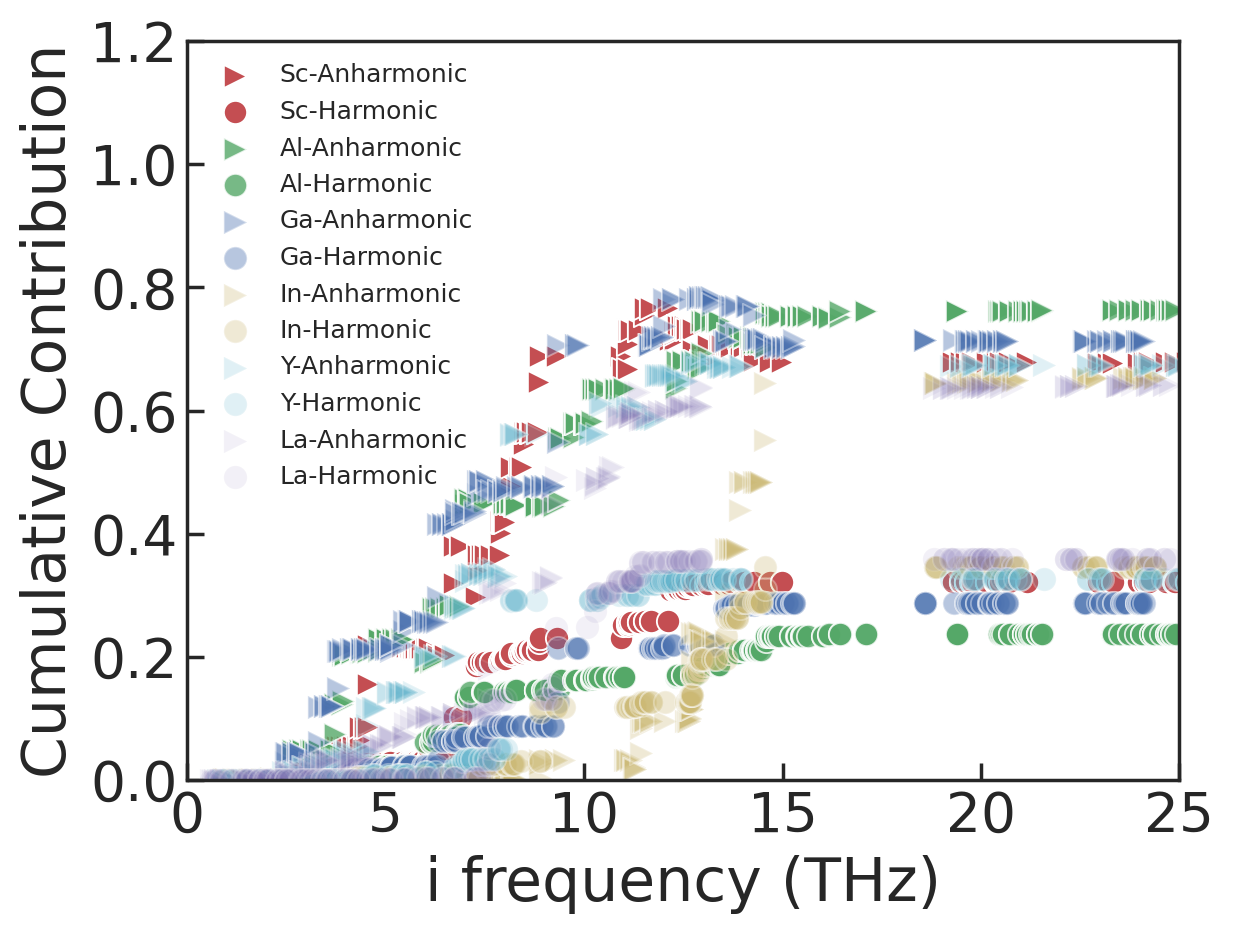

In [41]:
import seaborn as sns
# sns.set(font_scale=1.7,style='white')
# sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
list1 = ['Sc-Se','Al-Se','Ga-Se','In-Se','Y-Se','La-Se']
color_list = ['r','g','b','y','c','m']
sns.set(font_scale=1.8,style='white')
sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
alpha_list = [i/100 for i in[100,80,40,30,20,10]]
for j,i in enumerate(list1):
    temp = 900
    df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i}/phonon/{temp}k_norm_anharmonic_D1_total1.csv')
    print(len(df1))
    df5 = df1[df1['index i']==df1['index j']]
    df11 = df1[df1['index i']!=df1['index j']]
    df12 = df11.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
    df13 = df12.groupby(['i frequency (THz)']).agg({'Contribution D $_{\sigma}$':'sum'})
    df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
    df7 = copy.deepcopy(df5)
    # sns.set(font_scale=,style='white')
    sns.set_style(rc = {'ytick.left':True, 'xtick.bottom':True})
    plt.tick_params(direction='in')
    g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df13['Contribution D $_{\sigma}$'].values)/np.sum(df1['Contribution D $_{\sigma}$']),color=color_list[j],marker='>',s=70,label='1',alpha=alpha_list[j])
    g = sns.scatterplot( x=df7["i frequency (THz)"],y=np.cumsum(df7['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color=color_list[j],marker='o',s=70,label='2',alpha=alpha_list[j])
    # sns.ecdfplot(data=df9, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='r')
    # g = sns.scatterplot( x=df9["i frequency (THz)"],y=np.cumsum(df9['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='r',s=70)
    # g = sns.scatterplot( x=df10["i frequency (THz)"],y=np.cumsum(df10['Contribution D $_{\sigma}$'])/np.sum(df1['Contribution D $_{\sigma}$']),color='b',s=70)
    # sns.ecdfplot(data=df7, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='g')
    g.set_ylabel('Cumulative Contribution')
    g.set(xlim=(0, 25))
    g.set(ylim=(0, 1.2))
    fig = g.get_figure()
# plt.legend(,fontsize=5)
leg = plt.legend(labels = ['Sc-Anharmonic','Sc-Harmonic','Al-Anharmonic','Al-Harmonic','Ga-Anharmonic','Ga-Harmonic','In-Anharmonic','In-Harmonic','Y-Anharmonic','Y-Harmonic','La-Anharmonic','La-Harmonic'],fontsize=9,frameon=False)
leg.get_title().set_fontsize(8)
# leg = plt.legend(title=r'Modes',labels = ['Al','Ga','In','Sc','Y','La'],fontsize=10,frameon=False)
# leg.get_title().set_fontsize(8)
# fig.savefig(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/cdf_{temp}k_norm_anharmonic_D1_total1.png") 
# sns.ecdfplot(data=df10, x="i frequency (THz)",weights='Contribution D $_{\sigma}$',color='b')

In [13]:
df5 = df1[df1['index i']==df1['index j']]
df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df7 = copy.deepcopy(df5)

In [53]:
df3[df3['index i']==1]

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
56168,57599,1,1,24.907745,24.907745,2.655351e-20


In [97]:
df2 = df1.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
df3 = df2[df2['i frequency (THz)']==df2['j frequency (THz)']]
df3[0:20]

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
37366,38560,80,80,12.896139,12.896139,0.072034
28560,29643,117,117,8.894934,8.894934,0.063296
28798,29884,116,116,8.894934,8.894934,0.057870
35224,36391,89,89,12.679116,12.679116,0.034841
44506,45790,50,50,14.564168,14.564168,0.017653
44744,46031,49,49,14.564168,14.564168,0.012972
24514,25546,134,134,7.386682,7.386682,0.011840
39984,41211,69,69,13.583506,13.583506,0.011836
39746,40970,70,70,13.583506,13.583506,0.011238
36652,37837,83,83,12.728112,12.728112,0.006233


In [ ]:
df = pd.DataFrame(pd_res)
df = df[(df['i frequency (THz)']>0)&(df['j frequency (THz)']>0)&(df['i frequency (THz)']<25)&(df['j frequency (THz)']<25)]
df1 = copy.deepcopy(df)
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])

df3 = copy.deepcopy(df1)
print(len(df3))
# df3.loc[df3['Contribution D $_{\sigma}$'],'Contribution D $_{\sigma}$']=0
df4 = df3['Contribution D $_{\sigma}$'].values.reshape(int(np.sqrt(len(df3))),int(np.sqrt(len(df3))))
xr1 = xr.DataArray(data=df4,coords={'i frequency (THz)':np.unique(df1['i frequency (THz)']),'j frequency (THz)':np.unique(df1['j frequency (THz)'])},dims=['i frequency (THz)','j frequency (THz)'])
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.0,midpoint=4/19,stop=1.0)
# df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/900k_norm_anharmonic_D1.csv')
# cbar.set_label('Contribution D$_{\sigma}$',rotation=90,)
xr1.plot.contourf(vmin=-0.004,vmax=0.015,center=0,cmap=cm1,infer_intervals=False,add_colorbar=True,levels=1000,cbar_kwargs={'label':'Contribution D$_{\sigma}$'})


In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

freq1 = calculation.get_frequencies()
df = pd.DataFrame(pd_res)
df = df[(df['i frequency (THz)']>0)&(df['j frequency (THz)']>0)]#&(df['i frequency (THz)']<25)&(df['j frequency (THz)']<25)]
df1 = copy.deepcopy(df)
# list1 = ['Sc-Se']

# df = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon1/anharmonic_D1.csv',header=0)
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])
# df1.loc[(df1['i frequency (THz)']!=df1['j frequency (THz)']),'Contribution D $_{\sigma}$'] = 0
# from sklearn import preprocessing
df1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon/900k_norm_anharmonic_D1.csv')
fig,ax = plt.subplots(figsize=(10,8))
# colors = results/np.sum(results)
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=2/6,stop=0.95)
# ecut = 0.001
nbins=50
df3 = copy.deepcopy(df1)
print(len(df3))
# df3.loc[df3['Contribution D $_{\sigma}$'],'Contribution D $_{\sigma}$']=0
df4 = df3['Contribution D $_{\sigma}$'].values.reshape(int(np.sqrt(len(df3))),int(np.sqrt(len(df3))))
print(df4)
X,Y = np.meshgrid(np.unique(df1['i frequency (THz)']),np.unique(df1['j frequency (THz)']))
# levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(df4.min(),df4.max())
# a = ax.pcolormesh(X,Y,df4,cmap=cm1,vmin=-0.002,vmax=0.004) #vmin=-0.001,vmax=0.001)#,vmin=-0.002,vmax=0.002)#,)
a = ax.contour(X,Y,df4,cmap=cm1,origin='lower',levels=1000,vmin=-0.002,vmax=0.004)#,extent=[0,df1['i frequency (THz)'].values[-1],0,df1['i frequency (THz)'].values[-1]])#,vmin=-0.002,vmax=0.002)#,)
cbar = fig.colorbar(a,ax=ax,pad=0.1,fraction=0.036)
cbar.set_label('Contribution D$_{\sigma}$',rotation=90, labelpad=0.2,size=30)
# cbar.set_ticks(ticks=[0,0.04,0.08,0.12,0.16],size=30)
cbar.ax.tick_params(labelsize=20)
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_xlabel(f'i modes frequency (THz)',size=30)
ax.set_ylabel(f'j modes frequency (THz)',size=30)
ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax.set_xticks(ticks = [0,5,10,15,20,25])
ax.set_yticks(ticks = [0,5,10,15,20,25])
ax.set_xlim(0,25)
ax.set_ylim(0,25)#,
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(d, cmap=cmap,
#             square=True)vmax=0.0373

In [ ]:
df3

In [ ]:
list1

In [ ]:
# import seaborn as sns
# # df1 = pd.read_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/Al-Se/phonon/300k_norm_anharmonic_D1_total.csv')
# df5 = df1[df1['i frequency (THz)']==df1['j frequency (THz)']]
# df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
# g = sns.jointplot(x='i frequency (THz)', y='Contribution D $_{\sigma}$', data=df5,
#                   kind="scatter",
#                   xlim=(0, 25), ylim=(0, 0.1),
#                   color="g", height=7)
df1

In [32]:
df1['Contribution D $_{\sigma}$'] = df['Contribution D $_{\sigma}$']/np.sum(df['Contribution D $_{\sigma}$'])
df5 = df1[df1['i frequency (THz)']==df1['j frequency (THz)']]
df6 = df5.sort_values(by=['Contribution D $_{\sigma}$'],ascending=False)
# df5['index i'] ==0

In [34]:
df5

,Unnamed: 0,index i,index j,i frequency (THz),j frequency (THz),Contribution D $_{\sigma}$
0,723,237,237,1.473702,1.473702,3.194025e-06
238,964,236,236,1.502274,1.502274,1.437226e-31
476,1205,235,235,1.502275,1.502275,1.664436e-31
714,1446,234,234,1.766658,1.766658,2.952831e-32
952,1687,233,233,1.766658,1.766658,2.726449e-32
...,...,...,...,...,...,...
55216,56635,5,5,24.745688,24.745688,1.810982e-09
55454,56876,4,4,24.745688,24.745688,1.651699e-09
55692,57117,3,3,24.811743,24.811743,8.109937e-35
55930,57358,2,2,24.811744,24.811744,8.716039e-35


In [33]:
np.sum(df5['Contribution D $_{\sigma}$'])

0.2681326158385805

In [ ]:
df6[0:20]

In [ ]:
np.sum(df6['Contribution D $_{\sigma}$'])

In [10]:
class Quasiparticle:
    def __init__(self,
                 dynamic,
                 last_steps=None,
                 vc=None):

        self._dynamic = dynamic
        self._vc = vc
        self._eigenvectors = None
        self._frequencies = None
        self._vq = None
        self._power_spectrum_phonon = None
        self._power_spectrum_wave_vector = None
        self._power_spectrum_direct = None
        self._power_spectrum_partials = None
        self._bands = None
        self._renormalized_bands = None
        self._renormalized_force_constants = None
        self._commensurate_points_data = None
        self._temperature = None
        self._force_constants_qha = None
        self._parameters = parameters.Parameters()
        self.crop_trajectory(last_steps)
        #  print('Using {0} time steps for calculation'.format(len(self.dynamic.velocity)))

    # Crop trajectory
    def crop_trajectory(self, last_steps):
        if self._vc is None:
            self._dynamic.crop_trajectory(last_steps)
            print("Using {0} steps".format(len(self._dynamic.velocity)))
        else:
            if last_steps is not None:
                self._vc = self._vc[-last_steps:, :, :]
            print("Using {0} steps".format(len(self._vc)))

    # Memory clear methods
    def full_clear(self):
        self._eigenvectors = None
        self._frequencies = None
        self._vc = None
        self._vq = None
        self._power_spectrum_direct = None
        self._power_spectrum_wave_vector = None
        self._power_spectrum_phonon = None

    def power_spectra_clear(self):
        self._power_spectrum_phonon = None
        self._power_spectrum_wave_vector = None
        self._power_spectrum_direct = None
        self.force_constants_clear()

    def force_constants_clear(self):
        self._renormalized_force_constants = None
        self._commensurate_points_data = None
        self.bands_clear()

    def bands_clear(self):
        self._bands = None
        self._renormalized_bands = None

    # Properties
    @property
    def dynamic(self):
        return self._dynamic

    @property
    def parameters(self):
        return self._parameters

    def set_NAC(self, NAC):
        self._bands = None
        self.parameters.use_NAC = NAC

    def write_to_xfs_file(self, file_name):
        reading.write_xsf_file(file_name, self.dynamic.structure)

    def save_velocity_hdf5(self, file_name, save_trajectory=True):
        if save_trajectory:
            trajectory = self.dynamic.trajectory
        else:
            trajectory = None

        reading.save_data_hdf5(file_name,
                               self.dynamic.get_time(),
                               self.dynamic.get_supercell_matrix(),
                               velocity=self.dynamic.velocity,
                               trajectory=trajectory)

        print("Velocity saved in file " + file_name)

    def save_vc_hdf5(self, file_name):

        reading.save_data_hdf5(file_name,
                               self.dynamic.get_time(),
                               self.dynamic.get_supercell_matrix(),
                               vc=self.get_vc(),
                               reduced_q_vector=self.get_reduced_q_vector())

        print("Projected velocity saved in file " + file_name)

    def set_number_of_mem_coefficients(self, coefficients):
        self.power_spectra_clear()
        self.parameters.number_of_coefficients_mem = coefficients

    def set_projection_onto_atom_type(self, atom_type):
        if atom_type in range(self.dynamic.structure.get_number_of_primitive_atoms()):
            self.parameters.project_on_atom = atom_type
        else:
            print('Atom type {} does not exist'.format(atom_type))
            exit()

    def _set_frequency_range(self, frequency_range):
        if not np.array_equiv(np.array(frequency_range), np.array(self.parameters.frequency_range)):
            self.power_spectra_clear()
            self.parameters.frequency_range = frequency_range

    def set_spectra_resolution(self, resolution):
        limits = [self.get_frequency_range()[0], self.get_frequency_range()[-1]]
        self.parameters.spectrum_resolution = resolution
        self._set_frequency_range(np.arange(limits[0], limits[1] + resolution, resolution))

    def set_frequency_limits(self, limits):
        resolution = self.parameters.spectrum_resolution
        self._set_frequency_range(np.arange(limits[0], limits[1] + resolution, resolution))

    def get_frequency_range(self):
        return self.parameters.frequency_range

    # Wave vector related methods
    def set_reduced_q_vector(self, q_vector):
        if len(q_vector) == len(self.parameters.reduced_q_vector):
            if (np.array(q_vector) != self.parameters.reduced_q_vector).any():
                self.full_clear()

        self.parameters.reduced_q_vector = np.array(q_vector)

    def get_reduced_q_vector(self):
        return self.parameters.reduced_q_vector

    def get_q_vector(self):
        return np.dot(self.parameters.reduced_q_vector,
                      2.0 * np.pi * np.linalg.inv(self.dynamic.structure.get_primitive_cell()).T)

    # Phonopy harmonic calculation related methods
    def get_eigenvectors(self):
        if self._eigenvectors is None:
            # print("Getting frequencies & eigenvectors from Phonopy")
            self._eigenvectors, self._frequencies = (
                pho_interface.obtain_eigenvectors_and_frequencies(self.dynamic.structure,
                                                                  self.parameters.reduced_q_vector,test_orthonormal=True))
        return self._eigenvectors

    def get_frequencies(self):
        if self._frequencies is None:
            # print("Getting frequencies & eigenvectors from Phonopy")
            self._eigenvectors, self._frequencies = (
                pho_interface.obtain_eigenvectors_and_frequencies(self.dynamic.structure,
                                                                  self.parameters.reduced_q_vector))
        return self._frequencies

    def set_band_ranges(self, band_ranges):
        self.bands_clear()
        self.parameters.band_ranges = band_ranges

    def get_band_ranges_and_labels(self):
        # return self.parameters.band_ranges
        if self.parameters.band_ranges is None:
            self.parameters.band_ranges =  self.dynamic.structure.get_path_using_seek_path()

        return self.parameters.band_ranges

    def plot_phonon_dispersion_bands(self):
        bands = self.get_band_ranges_and_labels()

        band_ranges = bands['ranges']

        if self._bands is None:
            self._bands = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                                       band_ranges,
                                                                       NAC=self.parameters.use_NAC)

        for i, freq in enumerate(self._bands[1]):
            plt.plot(self._bands[1][i], self._bands[2][i], color='r')

            # plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_xaxis().set_ticks([])

        plt.ylabel('Frequency [THz]')
        plt.xlabel('Wave vector')
        plt.xlim([0, self._bands[1][-1][-1]])
        plt.axhline(y=0, color='k', ls='dashed')
        plt.suptitle('Phonon dispersion')

        if 'labels' in bands:
            plt.rcParams.update({'mathtext.default': 'regular'})

            labels = bands['labels']

            labels_e = []
            x_labels = []
            for i, freq in enumerate(self._bands[1]):
                if labels[i][0] == labels[i - 1][1]:
                    labels_e.append('$' + labels[i][0].replace('GAMMA', '\Gamma') + '$')
                else:
                    labels_e.append(
                        '$' + labels[i - 1][1].replace('GAMMA', '\Gamma') + '/' + labels[i][0].replace('GAMMA',
                                                                                                       '\Gamma') + '$')
                x_labels.append(self._bands[1][i][0])
            x_labels.append(self._bands[1][-1][-1])
            labels_e.append('$' + labels[-1][1].replace('GAMMA', '\Gamma') + '$')
            labels_e[0] = '$' + labels[0][0].replace('GAMMA', '\Gamma') + '$'

            plt.xticks(x_labels, labels_e, rotation='horizontal')

        plt.show()

    def plot_renormalized_phonon_dispersion_bands(self, plot_linewidths=False, plot_harmonic=True):

        bands_full_data = self.get_renormalized_phonon_dispersion_bands(with_linewidths=plot_linewidths)

        plot_title = 'Renormalized phonon dispersion relations'
        for i, path in enumerate(bands_full_data):

            plt.plot(path['q_path_distances'], np.array(list(path['renormalized_frequencies'].values())).T, color='r',
                     label='Renormalized')

            if plot_harmonic:
                plt.plot(path['q_path_distances'], np.array(list(path['harmonic_frequencies'].values())).T, color='b',
                         label='Harmonic')

            if plot_linewidths:
                for freq, linewidth in zip(list(path['renormalized_frequencies'].values()),
                                           list(path['linewidth'].values())):
                    plt.fill_between(path['q_path_distances'], freq + np.array(linewidth) / 2,
                                     freq - np.array(linewidth) / 2, color='r', alpha=0.2, interpolate=True,
                                     linewidth=0)
                    plot_title = 'Renormalized phonon dispersion relations and linewidths'

        # plt.axes().get_xaxis().set_visible(False)
        plt.suptitle(plot_title)
        plt.axes().get_xaxis().set_ticks([])
        plt.ylabel('Frequency [THz]')
        plt.xlabel('Wave vector')
        plt.xlim([0, bands_full_data[-1]['q_path_distances'][-1]])
        plt.axhline(y=0, color='k', ls='dashed')

        if plot_harmonic:
            handles = plt.gca().get_legend_handles_labels()[0]
            plt.legend([handles[-1], handles[0]], ['Harmonic', 'Renormalized'])

        if 'labels' in bands_full_data[0]:
            plt.rcParams.update({'mathtext.default': 'regular'})

            labels = [[bands_full_data[i]['labels']['inf'],
                       bands_full_data[i]['labels']['sup']]
                      for i in range(len(bands_full_data))]

            labels_e = []
            x_labels = []
            for i, freq in enumerate(bands_full_data):
                if labels[i][0] == labels[i - 1][1]:
                    labels_e.append('$' + labels[i][0].replace('GAMMA', '\Gamma') + '$')
                else:
                    labels_e.append(
                        '$' + labels[i - 1][1].replace('GAMMA', '\Gamma') + '/' + labels[i][0].replace('GAMMA',
                                                                                                       '\Gamma') + '$')
                x_labels.append(bands_full_data[i]['q_path_distances'][0])
            x_labels.append(bands_full_data[-1]['q_path_distances'][-1])
            labels_e.append('$' + labels[-1][1].replace('GAMMA', '\Gamma') + '$')
            labels_e[0] = '$' + labels[0][0].replace('GAMMA', '\Gamma') + '$'

            plt.xticks(x_labels, labels_e, rotation='horizontal')

        plt.show()

    def plot_linewidths_and_shifts_bands(self):

        bands_full_data = self.get_renormalized_phonon_dispersion_bands(with_linewidths=True,
                                                                        band_connection=True,
                                                                        interconnect_bands=True)
        number_of_branches = len(bands_full_data[0]['linewidth'])
        # print('number_of branches', number_of_branches)

        for i, path in enumerate(bands_full_data):
            prop_cicle = plt.rcParams['axes.prop_cycle']
            colors = prop_cicle.by_key()['color']

            for j in range(number_of_branches):
                plt.figure(0)
                branch = path['linewidth']['branch_{}'.format(j)]
                plt.plot(path['q_path_distances'], branch, color=np.roll(colors, -j)[0], label='linewidth')

                plt.figure(1)
                branch = path['harmonic_frequencies']['branch_{}'.format(j)]
                plt.plot(path['q_path_distances'], branch, color=np.roll(colors, -j)[0], label='linewidth')

                plt.figure(2)
                branch = path['frequency_shifts']['branch_{}'.format(j)]
                plt.plot(path['q_path_distances'], branch, color=np.roll(colors, -j)[0], label='linewidth')

                plt.figure(3)
                branch = path['renormalized_frequencies']['branch_{}'.format(j)]
                plt.plot(path['q_path_distances'], branch, color=np.roll(colors, -j)[0], label='linewidth')


        plt.figure(0)
        plt.suptitle('Phonon linewidths')

        plt.figure(1)
        plt.suptitle('Harmonic phonon dispersion relations')

        plt.figure(2)
        plt.suptitle('Frequency shifts')

        plt.figure(3)
        plt.suptitle('Renormalized phonon dispersion relations')

        for ifig in [0, 1, 2, 3]:
            plt.figure(ifig)

            plt.axes().get_xaxis().set_ticks([])
            plt.ylabel('Frequency [THz]')
            plt.xlabel('Wave vector')
            plt.xlim([0, bands_full_data[-1]['q_path_distances'][-1]])
            plt.axhline(y=0, color='k', ls='dashed')

            if 'labels' in bands_full_data[0]:
                plt.rcParams.update({'mathtext.default': 'regular'})

                labels = [[bands_full_data[i]['labels']['inf'],
                           bands_full_data[i]['labels']['sup']]
                          for i in range(len(bands_full_data))]

                labels_e = []
                x_labels = []
                for i, freq in enumerate(bands_full_data):
                    if labels[i][0] == labels[i - 1][1]:
                        labels_e.append('$' + labels[i][0].replace('GAMMA', '\Gamma') + '$')
                    else:
                        labels_e.append(
                            '$' + labels[i - 1][1].replace('GAMMA', '\Gamma') + '/' + labels[i][0].replace('GAMMA',
                                                                                                           '\Gamma') + '$')
                    x_labels.append(bands_full_data[i]['q_path_distances'][0])
                x_labels.append(bands_full_data[-1]['q_path_distances'][-1])
                labels_e.append('$' + labels[-1][1].replace('GAMMA', '\Gamma') + '$')
                labels_e[0] = '$' + labels[0][0].replace('GAMMA', '\Gamma') + '$'

                plt.xticks(x_labels, labels_e, rotation='horizontal')

        plt.show()

    def plot_frequencies_vs_linewidths(self):

        qpoints, multiplicity, frequencies, linewidths = self.get_mesh_frequencies_and_linewidths()

        plt.ylabel('Linewidth [THz]')
        plt.xlabel('Frequency [THz]')

        plt.axhline(y=0, color='k', ls='dashed')
        plt.title('Frequency vs linewidths (from mesh: {})'.format(self.parameters.mesh_phonopy))
        plt.scatter(np.array(frequencies).flatten(), np.array(linewidths).flatten(), s=multiplicity)
        plt.show()

    def get_renormalized_phonon_dispersion_bands(self,
                                                 with_linewidths=False,
                                                 interconnect_bands=False,
                                                 band_connection=False):

        def reconnect_eigenvectors(bands):
            order = range(bands[2][0].shape[1])
            for i, ev_bands in enumerate(bands[3]):
                if i > 0:
                    ref = bands[3][i-1][-1]
                    metric = np.abs(np.dot(ref.conjugate().T, ev_bands[0]))
                    order = np.argmax(metric, axis=1)
                    bands[2][i] = bands[2][i].T[order].T
                    bands[3][i] = bands[3][i].T[order].T

        def reconnect_frequencies(bands):
            order = range(bands[2][0].shape[1])
            for i, f_bands in enumerate(bands[2]):
                if i > 0:
                    order = []
                    ref = np.array(bands[2][i-1][-1]).copy()
                    for j, test_val in enumerate(f_bands[0]):
                        ov = np.argmin(np.abs(ref - test_val))
                        order.append(ov)
                        ref[ov] = 1000

                    # print(order)
                    bands[2][i] = bands[2][i].T[order].T
                    bands[3][i] = bands[3][i].T[order].T

        def eigenvector_order(ev_bands, ev_renormalized):
            metric = np.zeros_like(np.abs(np.dot(ev_bands[0].conjugate().T, ev_renormalized[0])))
            for ev_ref, ev in zip(ev_bands, ev_renormalized):
                metric += np.abs(np.dot(ev_ref.conjugate().T, ev))
            order = np.argmax(metric, axis=1,)
            return order

        def set_order(bands, renormalized_bands):
            order_list = []
            for ev_bands, ev_renormalized in zip(bands[3], renormalized_bands[3]):
                order = eigenvector_order(ev_bands, ev_renormalized)
                order_list.append(order)

            freq = np.array(renormalized_bands[2]).copy()
            for i, o in enumerate(order_list):
                renormalized_bands[2][i] = freq[i].T[o].T

        renormalized_force_constants = self.get_renormalized_force_constants()
        bands = self.get_band_ranges_and_labels()
        band_ranges = bands['ranges']

        _bands = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                              band_ranges,
                                                              NAC=self.parameters.use_NAC,
                                                              band_connection=band_connection,
                                                              band_resolution=self.parameters.band_resolution)

        if interconnect_bands:
            # reconnect_frequencies(_bands)
            reconnect_eigenvectors(_bands)

        _renormalized_bands = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                                           band_ranges,
                                                                           force_constants=renormalized_force_constants,
                                                                           NAC=self.parameters.use_NAC,
                                                                           band_connection=band_connection,
                                                                           band_resolution=self.parameters.band_resolution)
        if band_connection:
            set_order(_bands, _renormalized_bands)

        data = self.get_commensurate_points_data()
        renormalized_frequencies = data['frequencies']
        eigenvectors = data['eigenvectors']
        linewidths = data['linewidths']
        fc_supercell = data['fc_supercell']

        sup_lim = pho_interface.get_renormalized_force_constants(renormalized_frequencies + linewidths / 2,
                                                                 eigenvectors,
                                                                 self.dynamic.structure,
                                                                 fc_supercell,
                                                                 symmetrize=self.parameters.symmetrize)

        inf_lim = pho_interface.get_renormalized_force_constants(renormalized_frequencies - linewidths / 2,
                                                                 eigenvectors,
                                                                 self.dynamic.structure,
                                                                 fc_supercell,
                                                                 symmetrize=self.parameters.symmetrize)

        if with_linewidths:
            renormalized_bands_s = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                                                band_ranges,
                                                                                force_constants=sup_lim,
                                                                                NAC=self.parameters.use_NAC,
                                                                                band_connection=band_connection,
                                                                                band_resolution=self.parameters.band_resolution)

            renormalized_bands_i = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                                                band_ranges,
                                                                                force_constants=inf_lim,
                                                                                NAC=self.parameters.use_NAC,
                                                                                band_connection=band_connection,
                                                                                band_resolution=self.parameters.band_resolution)

            if band_connection:
                set_order(_bands, renormalized_bands_s)
                set_order(_bands, renormalized_bands_i)

        bands_full_data = []
        for i, q_path in enumerate(_bands[1]):

            band = {'q_path_distances': q_path.tolist(),
                    'q_bounds': {'inf': list(band_ranges[i][0]), 'sup': list(band_ranges[i][1])},
                    'harmonic_frequencies': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                             enumerate(_bands[2][i].T)},
                    'renormalized_frequencies': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                                 enumerate(_renormalized_bands[2][i].T)},
                    'frequency_shifts': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                         enumerate(_renormalized_bands[2][i].T - _bands[2][i].T)},
                    }

            if with_linewidths:
                band.update({'linewidth_minus': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                                 enumerate(renormalized_bands_i[2][i].T)},
                             'linewidth_plus': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                                enumerate(renormalized_bands_s[2][i].T)},
                             'linewidth': {'branch_{}'.format(key): value.tolist() for (key, value) in
                                           enumerate(renormalized_bands_s[2][i].T - renormalized_bands_i[2][i].T)}}
                            )

            if 'labels' in bands:
                labels = bands['labels']
                band.update({'labels': {'inf': labels[i][0], 'sup': labels[i][1]}})

            bands_full_data.append(band)

        return bands_full_data

    def get_mesh_frequencies_and_linewidths(self):

        data = self.get_commensurate_points_data()

        renormalized_frequencies = data['frequencies']
        eigenvectors = data['eigenvectors']
        linewidths = data['linewidths']
        fc_supercell = data['fc_supercell']

        linewidths_fc = pho_interface.get_renormalized_force_constants(linewidths,
                                                                   eigenvectors,
                                                                   self.dynamic.structure,
                                                                   fc_supercell,
                                                                   symmetrize=self.parameters.symmetrize)

        _, _, linewidths_mesh = pho_interface.obtain_phonopy_mesh_from_force_constants(self.dynamic.structure,
                                                                                       force_constants=linewidths_fc,
                                                                                       mesh=self.parameters.mesh_phonopy,
                                                                                       NAC=None)

        frequencies_fc = pho_interface.get_renormalized_force_constants(renormalized_frequencies,
                                                                        eigenvectors,
                                                                        self.dynamic.structure,
                                                                        fc_supercell,
                                                                        symmetrize=self.parameters.symmetrize)

        qpoints, multiplicity, frequencies_mesh = pho_interface.obtain_phonopy_mesh_from_force_constants(self.dynamic.structure,
                                                                                        force_constants=frequencies_fc,
                                                                                        mesh=self.parameters.mesh_phonopy,
                                                                                        NAC=None)

        return qpoints, multiplicity, frequencies_mesh, linewidths_mesh

    def write_renormalized_phonon_dispersion_bands(self, filename='bands_data.yaml'):
        bands_full_data = self.get_renormalized_phonon_dispersion_bands(with_linewidths=True, band_connection=True)
        reading.save_bands_data_to_file(bands_full_data, filename)

    def print_phonon_dispersion_bands(self):
        if self._bands is None:
            self._bands = pho_interface.obtain_phonon_dispersion_bands(self.dynamic.structure,
                                                                       self.get_band_ranges_and_labels(),
                                                                       NAC=self.parameters.use_NAC)
        np.set_printoptions(linewidth=200)
        for i, freq in enumerate(self._bands[1]):
            print(str(np.hstack([self._bands[1][i][None].T, self._bands[2][i]])).replace('[', '').replace(']', ''))

    def plot_eigenvectors(self):
        modes.plot_phonon_modes(self.dynamic.structure,
                                self.get_eigenvectors(),
                                self.get_q_vector(),
                                vectors_scale=self.parameters.modes_vectors_scale)

    def plot_dos_phonopy(self, force_constants=None):

        phonopy_dos = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                       mesh=self.parameters.mesh_phonopy,
                                                       projected_on_atom=self.parameters.project_on_atom,
                                                       NAC=self.parameters.use_NAC)

        plt.plot(phonopy_dos[0], phonopy_dos[1], 'b-', label='Harmonic')

        if force_constants is not None:
            phonopy_dos_r = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                             mesh=self.parameters.mesh_phonopy,
                                                             force_constants=force_constants,
                                                             projected_on_atom=self.parameters.project_on_atom,
                                                             NAC=self.parameters.use_NAC)

            plt.plot(phonopy_dos_r[0], phonopy_dos_r[1], 'g-', label='Renormalized')

        plt.title('Density of states (Normalized to unit cell)')
        plt.xlabel('Frequency [THz]')
        plt.ylabel('Density of states')
        plt.legend()
        plt.axhline(y=0, color='k', ls='dashed')
        plt.show()

    def check_commensurate(self, q_point, decimals=4):
        supercell = self.dynamic.get_supercell_matrix()

        commensurate = False
        primitive_matrix = self.dynamic.structure.get_primitive_matrix()

        transform = np.dot(q_point, np.linalg.inv(primitive_matrix))
        transform = np.multiply(transform, supercell)
        transform = np.around(transform, decimals=decimals)

        if np.all(np.equal(np.mod(transform, 1), 0)):
            commensurate = True

        return commensurate

    # Projections related methods
    def get_vc(self):
        if self._vc is None:
            print("Projecting into wave vector")
            # Check if commensurate point
            if not self.check_commensurate(self.get_reduced_q_vector()):
                print("warning! This wave vector is not a commensurate q-point in MD supercell")

            if self.parameters.project_on_atom > -1:
                element = self.dynamic.structure.get_atomic_elements(unique=True)[self.parameters.project_on_atom]
                print('Project on atom {} : {}'.format(self.parameters.project_on_atom, element))

            self._vc = projection.project_onto_wave_vector(self.dynamic,
                                                           self.get_q_vector(),
                                                           project_on_atom=self.parameters.project_on_atom)
        return self._vc

    def get_vq(self):
        if self._vq is None:
            print("Projecting into phonon mode")
            self._vq = projection.project_onto_phonon(self.get_vc(), self.get_eigenvectors())
        return self._vq

    def plot_vq(self, modes=None):
        if not modes:
            modes = [0]
        plt.suptitle('Phonon mode projection')
        plt.xlabel('Time [ps]')
        plt.ylabel('$u^{1/2}\AA/ps$')

        time = np.linspace(0, self.get_vc().shape[0] * self.dynamic.get_time_step_average(),
                           num=self.get_vc().shape[0])

        for mode in modes:
            plt.plot(time, self.get_vq()[:, mode].real, label='mode: ' + str(mode))
        plt.legend()
        plt.show()

    def plot_vc(self, atoms=None, coordinates=None):
        if not atoms:
            atoms = [0]
        if not coordinates:
            coordinates = [0]
        time = np.linspace(0, self.get_vc().shape[0] * self.dynamic.get_time_step_average(),
                           num=self.get_vc().shape[0])

        plt.suptitle('Wave vector projection')
        plt.xlabel('Time [ps]')
        plt.ylabel('$u^{1/2}\AA/ps$')

        for atom in atoms:
            for coordinate in coordinates:
                plt.plot(time,
                         self.get_vc()[:, atom, coordinate].real,
                         label='atom: ' + str(atom) + ' coordinate:' + str(coordinate))
        plt.legend()
        plt.show()

    def save_vc(self, file_name, atom=0):
        print("Saving wave vector projection to file")
        np.savetxt(file_name, self.get_vc()[:, atom, :].real)

    def save_vq(self, file_name):
        print("Saving phonon projection to file")
        np.savetxt(file_name, self.get_vq().real)

    # Power spectra related methods
    def select_power_spectra_algorithm(self, algorithm):
        if algorithm in power_spectrum_functions.keys():
            if algorithm != self.parameters.power_spectra_algorithm:
                self.power_spectra_clear()
                self.parameters.power_spectra_algorithm = algorithm
            print("Using {0} function".format(power_spectrum_functions[algorithm][1]))
        else:
            print("Power spectrum algorithm number not found!\nPlease select:")
            for i in power_spectrum_functions.keys():
                print('{0} : {1}'.format(i, power_spectrum_functions[i][1]))
            exit()

    def select_fitting_function(self, function):
        from dynaphopy.analysis.fitting.fitting_functions import fitting_functions
        if function in fitting_functions.keys():
            if function != self.parameters.fitting_function:
                self.force_constants_clear()
                self.parameters.fitting_function = function
        else:
            print("Fitting function number not found!\nPlease select:")
            for i in fitting_functions.keys():
                print('{0} : {1}'.format(i, fitting_functions[i]))
            exit()

    def get_power_spectrum_phonon(self):
        if self._power_spectrum_phonon is None:
            print("Calculating phonon projection power spectra")

            if self.parameters.use_symmetry:
                initial_reduced_q_point = self.get_reduced_q_vector()
                power_spectrum_phonon = []
                q_points_equivalent = pho_interface.get_equivalent_q_points_by_symmetry(self.get_reduced_q_vector(),
                                                                                        self.dynamic.structure)
                #                print(q_points_equivalent)
                for q_point in q_points_equivalent:
                    self.set_reduced_q_vector(q_point)
                    power_spectrum_phonon.append(
                        (power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](self.get_vq(),
                                                                                               self.dynamic,
                                                                                               self.parameters))

                self.set_reduced_q_vector(initial_reduced_q_point)
                self._power_spectrum_phonon = np.average(power_spectrum_phonon, axis=0)
            else:
                self._power_spectrum_phonon = (
                    power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](self.get_vq(),
                                                                                          self.dynamic,
                                                                                          self.parameters)

        return self._power_spectrum_phonon

    def get_power_spectrum_wave_vector(self):

        if self._power_spectrum_wave_vector is None:
            print('Calculating wave vector projection power spectrum')
            size = self.get_vc().shape[1] * self.get_vc().shape[2]
            if self.parameters.use_symmetry:
                initial_reduced_q_point = self.get_reduced_q_vector()
                power_spectrum_wave_vector = []
                q_points_equivalent = pho_interface.get_equivalent_q_points_by_symmetry(self.get_reduced_q_vector(),
                                                                                        self.dynamic.structure)
                #  print(q_points_equivalent)
                for q_point in q_points_equivalent:
                    self.set_reduced_q_vector(q_point)

                    power_spectrum_wave_vector.append((power_spectrum_functions[
                                                           self.parameters.power_spectra_algorithm])[0](
                        self.get_vc().swapaxes(1, 2).reshape(-1, size),
                        self.dynamic,
                        self.parameters))
                power_spectrum_wave_vector = np.array(power_spectrum_wave_vector)
                self.set_reduced_q_vector(initial_reduced_q_point)

                self._power_spectrum_wave_vector = np.average(power_spectrum_wave_vector, axis=0)

            else:
                self._power_spectrum_wave_vector = (
                    power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](
                    self.get_vc().swapaxes(1, 2).reshape(-1, size),
                    self.dynamic,
                    self.parameters)

        return np.nansum(self._power_spectrum_wave_vector, axis=1)

    def get_power_spectrum_full(self, projection_on_coordinate=-1):

        # temporal interface
        number_of_dimensions = self.dynamic.structure.get_number_of_dimensions()
        projected_atom_type = self.parameters.project_on_atom

        if self._power_spectrum_direct is None:
            print("Calculation full power spectrum")

            velocity_mass_average = self.dynamic.get_velocity_mass_average()

            if projected_atom_type >= 0:
                print('Power spectrum projected onto atom type {0}'.format(projected_atom_type))
                supercell = self.dynamic.get_supercell_matrix()
                atom_types = np.array(self.dynamic.structure.get_atom_type_index(supercell=supercell))
                atom_indices = np.argwhere(atom_types == projected_atom_type).flatten()
                if len(atom_indices) == 0:
                    print('Atom type {0} does not exist'.format(projected_atom_type))
                    exit()

                # Only works if project on atom is requested!
                if projection_on_coordinate >= number_of_dimensions:
                    print('Projected coordinate should be smaller than {}'.format(number_of_dimensions))
                    exit()
                if projection_on_coordinate > -1:
                    print('Power spectrum projected onto coordinate {}'.format(projection_on_coordinate))
                    velocity_mass_average = velocity_mass_average[:, atom_indices, projection_on_coordinate, None]
                else:
                    velocity_mass_average = velocity_mass_average[:, atom_indices]

            size = velocity_mass_average.shape[1] * velocity_mass_average.shape[2]

            # Memory efficient algorithm
            if self.parameters.silent:
                self._power_spectrum_direct = np.zeros_like(self.parameters.frequency_range[None].T)
                for i in range(velocity_mass_average.shape[1]):
                    for j in range(velocity_mass_average.shape[2]):
                        self._power_spectrum_direct += \
                            (power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](
                                velocity_mass_average[:, i, j][None].T,
                                self.dynamic,
                                self.parameters)

            else:
                self._power_spectrum_direct = (power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](
                    velocity_mass_average.swapaxes(1, 2).reshape(-1, size),
                    self.dynamic,
                    self.parameters)

            self._power_spectrum_direct = np.sum(self._power_spectrum_direct, axis=1)
        return self._power_spectrum_direct

    def get_power_spectrum_partials(self, save_to_file=None):

        if self._power_spectrum_partials is None:
            print("Calculation power spectrum partials")

            velocity_mass_average = self.dynamic.get_velocity_mass_average()

            self._power_spectrum_partials = (power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](
                velocity_mass_average[:, :, 0],
                self.dynamic,
                self.parameters)

            for i in [1, 2]:
                self._power_spectrum_partials += (power_spectrum_functions[self.parameters.power_spectra_algorithm])[0](
                    velocity_mass_average[:, :, i],
                    self.dynamic,
                    self.parameters)

        if save_to_file is not None:
            np.savetxt(save_to_file, np.hstack([self.get_frequency_range()[None].T, self._power_spectrum_partials]))

        return self._power_spectrum_partials

    def phonon_width_scan_analysis(self):
        print("Phonon coefficient scan analysis(Maximum entropy method/Symmetric Lorentzian fit only)")
        power_spectrum.mem_coefficient_scan_analysis(self.get_vq(), self.dynamic, self.parameters)

    def phonon_individual_analysis(self):
        print("Peak analysis analysis")

        fitting.phonon_fitting_analysis(self.get_power_spectrum_phonon(),
                                        self.parameters.frequency_range,
                                        harmonic_frequencies=self.get_frequencies(),
                                        thermal_expansion_shift=self.get_qha_shift(self.get_reduced_q_vector()),
                                        show_plots=not self.parameters.silent,
                                        fitting_function_type=self.parameters.fitting_function,
                                        use_degeneracy=self.parameters.use_symmetry,
                                        show_occupancy=self.parameters.project_on_atom < 0  # temporal interface
                                        )
        return

    def plot_power_spectrum_full(self):

        fig, ax1 = plt.subplots()

        ax1.plot(self.get_frequency_range(), self.get_power_spectrum_full(), 'r-', label='Power spectrum (MD)')
        ax1.set_xlabel('Frequency [THz]')
        ax1.set_ylabel('eV * ps')
        ax2 = ax1.twinx()

        if self.dynamic.structure.forces_available():
            phonopy_dos = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                           mesh=self.parameters.mesh_phonopy,
                                                           freq_min=self.get_frequency_range()[0],
                                                           freq_max=self.get_frequency_range()[-1],
                                                           projected_on_atom=self.parameters.project_on_atom,
                                                           NAC=self.parameters.use_NAC)

            ax2.plot(phonopy_dos[0], phonopy_dos[1], 'b-', label='DoS (Lattice dynamics)')
            ax2.set_ylabel('Density of states')

        if self._renormalized_force_constants is not None:
            phonopy_dos_r = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                             mesh=self.parameters.mesh_phonopy,
                                                             freq_min=self.get_frequency_range()[0],
                                                             freq_max=self.get_frequency_range()[-1],
                                                             force_constants=self._renormalized_force_constants,
                                                             projected_on_atom=self.parameters.project_on_atom,
                                                             NAC=self.parameters.use_NAC)

            ax2.plot(phonopy_dos_r[0], phonopy_dos_r[1], 'g-', label='Renormalized DoS')

        plt.suptitle('Full power spectrum')

        handles1, labels = ax1.get_legend_handles_labels()
        handles2, labels = ax2.get_legend_handles_labels()

        handles = handles1 + handles2
        plt.legend(handles, ['Power spectrum (MD)', 'DoS (Harmonic)', 'DoS (Renormalized)'])
        # plt.legend()
        plt.show()

        total_integral = integrate.simps(self.get_power_spectrum_full(), x=self.get_frequency_range())
        print("Total Area (Kinetic energy <K>): {0} eV".format(total_integral))

    def plot_power_spectrum_wave_vector(self):
        plt.suptitle('Projection onto wave vector')
        plt.plot(self.get_frequency_range(), self.get_power_spectrum_wave_vector(), 'r-')
        plt.xlabel('Frequency [THz]')
        plt.ylabel('eV * ps')
        plt.axhline(y=0, color='k', ls='dashed')
        plt.show()
        total_integral = integrate.simps(self.get_power_spectrum_wave_vector(), x=self.get_frequency_range())
        print("Total Area (Kinetic energy <K>): {0} eV".format(total_integral))

    def plot_power_spectrum_phonon(self):
        for i in range(self.get_power_spectrum_phonon().shape[1]):
            plt.figure(i)
            plt.suptitle('Projection onto phonon mode {0}'.format(i + 1))
            plt.plot(self.get_frequency_range(), self.get_power_spectrum_phonon()[:, i])
            plt.xlabel('Frequency [THz]')
            plt.ylabel('eV * ps')
            plt.axhline(y=0, color='k', ls='dashed')

        plt.show()

    # Plot dynamical properties related methods
    def plot_trajectory(self, atoms=None, coordinates=None):
        if atoms is None: atoms = [0]
        if coordinates is None: coordinates = [0]

        plt.suptitle('Trajectory')
        time = np.linspace(0, self.dynamic.trajectory.shape[0] * self.dynamic.get_time_step_average(),
                           num=self.dynamic.trajectory.shape[0])
        for atom in atoms:
            for coordinate in coordinates:
                plt.plot(time, self.dynamic.trajectory[:, atom, coordinate].real,
                         label='atom: {0}  coordinate: {1}'.format(atom, coordinate))

        plt.legend()
        plt.xlabel('Time [ps]')
        plt.ylabel('Angstrom')
        plt.show()

    def plot_velocity(self, atoms=None, coordinates=None):
        if not atoms: atoms = [0]
        if not coordinates: coordinates = [0]

        plt.suptitle('Velocity')
        time = np.linspace(0, self.dynamic.velocity.shape[0] * self.dynamic.get_time_step_average(),
                           num=self.dynamic.velocity.shape[0])

        for atom in atoms:
            for coordinate in coordinates:
                plt.plot(time, self.dynamic.velocity[:, atom, coordinate].real,
                         label='atom: {0}  coordinate: {1}'.format(atom, coordinate))

        plt.legend()
        plt.xlabel('Time [ps]')
        plt.ylabel('$\AA/ps$')
        plt.show()

    def plot_energy(self):
        plt.suptitle('Energy')
        plt.plot(self.dynamic.get_time().real,
                 self.dynamic.get_energy().real)
        plt.show()

    def plot_trajectory_distribution(self, direction):
        from dynaphopy.analysis.fitting.fitting_functions import Gaussian_function

        atomic_types = self.dynamic.structure.get_atomic_elements()
        atom_type_index_unique = np.unique(self.dynamic.structure.get_atom_type_index(), return_index=True)[1]
        atomic_types_unique = [atomic_types[i] for i in atom_type_index_unique]

        direction = np.array(direction)

        distributions, distance = self.get_atomic_displacements(direction)

        plt.figure()
        for atom in range(distributions.shape[0]):

            plt.figure(atom + 1)
            plt.title('Atomic displacements')
            plt.suptitle('Atom {0}, Element {1}'.format(atom, atomic_types_unique[atom]))

            width = (distance[1] - distance[0])
            center = (distance[:-1] + distance[1:] + width) / 2

            print('\nAtom {0}, Element {1}'.format(atom, atomic_types_unique[atom]))
            print('-----------------------------------------')
            try:

                distance_centers = distance[:-1] + width
                fitting_function = Gaussian_function(distance_centers,
                                                     distributions[atom],
                                                     guess_height=1,
                                                     guess_position=0)

                parameters = fitting_function.get_fitting()
                print('Mean               {0:15.6f} Angstrom'.format(parameters['peak_position']))
                print('Standard deviation {0:15.6f} Angstrom'.format(parameters['width']))
                print('Global fit error   {0:15.6f}'.format(parameters['global_error']))

                plt.plot(distance, fitting_function.get_curve(distance),
                         label=fitting_function.curve_name,
                         linewidth=3, color='g')
            except:
                print('Gaussian fitting failed')

            plt.bar(center, distributions[atom], align='center', width=width)
            plt.xlabel('Direction: ' + ' '.join(np.array(direction, dtype=str)) + ' [Angstrom]')
            plt.xlim([distance[0], distance[-1]])
            plt.ylim([0, None])
            plt.axhline(y=0, color='k', ls='dashed')
            plt.legend()
        plt.show()

    # Printing data to files
    def write_power_spectrum_full(self, file_name):
        reading.write_curve_to_file(self.get_frequency_range(),
                                    self.get_power_spectrum_full()[None].T,
                                    file_name)
        total_integral = integrate.simps(self.get_power_spectrum_full(), x=self.get_frequency_range())
        print("Total Area (Kinetic energy <K>): {0} eV".format(total_integral))

    def write_power_spectrum_wave_vector(self, file_name):
        reading.write_curve_to_file(self.get_frequency_range(),
                                    self.get_power_spectrum_wave_vector()[None].T,
                                    file_name)
        total_integral = integrate.simps(self.get_power_spectrum_wave_vector(), x=self.get_frequency_range())
        print("Total Area (Kinetic energy <K>): {0} eV".format(total_integral))

    def write_power_spectrum_phonon(self, file_name):
        reading.write_curve_to_file(self.get_frequency_range(),
                                    self.get_power_spectrum_phonon(),
                                    file_name)

    def get_atomic_displacements(self, direction):

        number_of_bins = self.parameters.number_of_bins_histogram
        direction = np.array(direction)

        projections = trajdist.trajectory_projection(self.dynamic, direction)

        min_val = np.amin(projections)
        max_val = np.amax(projections)

        bins = None
        distributions = []
        for atom in range(projections.shape[0]):
            distribution, bins = np.histogram(projections[atom],
                                              bins=number_of_bins,
                                              range=(min_val, max_val),
                                              normed=True)

            distributions.append(distribution)

        distance = np.array([i_bin - (bins[1] - bins[0]) / 2 for i_bin in bins])

        return np.array(distributions), distance

    def write_atomic_displacements(self, direction, file_name):
        distributions, distance = self.get_atomic_displacements(direction)
        reading.write_curve_to_file(distance, distributions.T, file_name)

    # Molecular dynamics analysis related methods
    def show_boltzmann_distribution(self):
        energy.boltzmann_distribution(self.dynamic, self.parameters)

    def get_temperature(self):
        if not self._temperature:
            save_status = self.parameters.silent
            self.parameters.silent = True
            self._temperature = energy.boltzmann_distribution(self.dynamic, self.parameters)
            self.parameters.silent = save_status
        return self._temperature

    def set_temperature(self, temperature):
        self._temperature = temperature

    def get_algorithm_list(self):
        return power_spectrum_functions.values()

    def get_commensurate_points_data(self, auto_range=True):

        if self._commensurate_points_data is None:

            if auto_range:
                # Get range from harmonic DOS
                phonopy_dos = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                               mesh=self.parameters.mesh_phonopy)

                self.set_frequency_limits([0, np.max(phonopy_dos[0][-1]) * 1.2])
                print('set frequency range: {} - {}'.format(self.get_frequency_range()[0],
                                                            self.get_frequency_range()[-1]))

            # Decide the size of the supercell to use to calculate the renormalized force constants
            if self._parameters.use_MD_cell_commensurate:
                fc_supercell = np.diag(self.dynamic.get_supercell_matrix())
            else:
                fc_supercell = self.dynamic.structure.get_supercell_phonon()

            com_points = pho_interface.get_commensurate_points(self.dynamic.structure,
                                                               fc_supercell)

            initial_reduced_q_vector = self.get_reduced_q_vector()

            renormalized_frequencies = []
            frequency_shifts = []
            eigenvectors = []
            linewidths = []
            q_points_list = []

            for i, reduced_q_vector in enumerate(com_points):

                print("\nQ-point: {0} / {1}      {2}".format(i + 1, len(com_points), reduced_q_vector))

                self.set_reduced_q_vector(reduced_q_vector)
                eigenvectors.append(self.get_eigenvectors())

                q_points_equivalent = pho_interface.get_equivalent_q_points_by_symmetry(reduced_q_vector,
                                                                                        self.dynamic.structure)
                q_index = _vector_in_list(q_points_equivalent, q_points_list)
                q_points_list.append(reduced_q_vector)

                if q_index != 0 and self.parameters.use_symmetry:
                    renormalized_frequencies.append(renormalized_frequencies[q_index])
                    linewidths.append(linewidths[q_index])
                    frequency_shifts.append(frequency_shifts[q_index])

                    print('Skipped, equivalent to {0}'.format(q_points_list[q_index]))
                    continue

                self.set_reduced_q_vector(reduced_q_vector)

                data = fitting.phonon_fitting_analysis(self.get_power_spectrum_phonon(),
                                                       self.parameters.frequency_range,
                                                       harmonic_frequencies=self.get_frequencies(),
                                                       thermal_expansion_shift=self.get_qha_shift(reduced_q_vector),
                                                       show_plots=False,
                                                       fitting_function_type=self.parameters.fitting_function,
                                                       use_degeneracy=self.parameters.use_symmetry)

                positions = data['positions']
                widths = data['widths']
                if (reduced_q_vector == [0, 0, 0]).all():
                    print('Fixing gamma point 0 frequencies')
                    positions[0] = 0.
                    positions[1] = 0.
                    positions[2] = 0.
                    widths[0] = 0.
                    widths[1] = 0.
                    widths[2] = 0.

                renormalized_frequencies.append(positions)
                linewidths.append(widths)
                frequency_shifts.append(np.array(positions) - self.get_frequencies())

            renormalized_frequencies = np.array(renormalized_frequencies)
            linewidths = np.array(linewidths)
            frequency_shifts = np.array(frequency_shifts)

            # To be deprecated
            if self.parameters.save_renormalized_frequencies:
                print("This option will be deprecated in the future. Please use save quasiparticle data option")
                np.savetxt('renormalized_frequencies', renormalized_frequencies)
            # np.savetxt('test_line', linewidths)

            self._commensurate_points_data = {'frequencies': renormalized_frequencies,
                                              'eigenvectors': eigenvectors,
                                              'linewidths': linewidths,
                                              'frequency_shifts': frequency_shifts,
                                              'q_points': q_points_list,
                                              'fc_supercell': fc_supercell}

            self.set_reduced_q_vector(initial_reduced_q_vector)

        return self._commensurate_points_data

    def get_renormalized_force_constants(self):
        data = self.get_commensurate_points_data()
        renormalized_frequencies = data['frequencies']
        eigenvectors = data['eigenvectors']
        fc_supercell = data['fc_supercell']

        if self._renormalized_force_constants is None:
            self._renormalized_force_constants = pho_interface.get_renormalized_force_constants(
                renormalized_frequencies,
                eigenvectors,
                self.dynamic.structure,
                fc_supercell,
                symmetrize=self.parameters.symmetrize)

        return self._renormalized_force_constants

    def write_renormalized_constants(self, filename="FORCE_CONSTANTS"):
        force_constants = self.get_renormalized_force_constants()
        pho_interface.save_force_constants_to_file(force_constants, filename)

    def write_quasiparticles_data(self, filename="quasiparticles_data.yaml"):
        quasiparticle_data = self.get_commensurate_points_data()
        reading.save_quasiparticle_data_to_file(quasiparticle_data, filename)

    def write_mesh_data(self, file_name='mesh_data.yaml'):
        mesh_data = self.get_mesh_frequencies_and_linewidths()
        reading.save_mesh_data_to_yaml_file(mesh_data, file_name)

    def get_thermal_properties(self, force_constants=None):

        temperature = self.get_temperature()

        phonopy_dos = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                       mesh=self.parameters.mesh_phonopy,
                                                       freq_min=0.01,
                                                       freq_max=self.get_frequency_range()[-1],
                                                       force_constants=force_constants,
                                                       projected_on_atom=self.parameters.project_on_atom,
                                                       NAC=self.parameters.use_NAC)

        free_energy = thm.get_free_energy(temperature, phonopy_dos[0], phonopy_dos[1])
        entropy = thm.get_entropy(temperature, phonopy_dos[0], phonopy_dos[1])
        c_v = thm.get_cv(temperature, phonopy_dos[0], phonopy_dos[1])
        integration = integrate.simps(phonopy_dos[1], x=phonopy_dos[0]) / (
            self.dynamic.structure.get_number_of_atoms() *
            self.dynamic.structure.get_number_of_dimensions())
        total_energy = thm.get_total_energy(temperature, phonopy_dos[0], phonopy_dos[1])

        if force_constants is not None:
            # Free energy correction
            phonopy_dos_h = pho_interface.obtain_phonopy_dos(self.dynamic.structure,
                                                             mesh=self.parameters.mesh_phonopy,
                                                             freq_min=0.01,
                                                             freq_max=self.get_frequency_range()[-1],
                                                             projected_on_atom=self.parameters.project_on_atom,
                                                             NAC=self.parameters.use_NAC)

            free_energy += thm.get_free_energy_correction_dos(temperature, phonopy_dos_h[0], phonopy_dos_h[1],
                                                              phonopy_dos[1])
            total_energy += thm.get_free_energy_correction_dos(temperature, phonopy_dos_h[0], phonopy_dos_h[1],
                                                               phonopy_dos[1])

            # correction = thm.get_free_energy_correction_dos(temperature, phonopy_dos_h[0], phonopy_dos_h[1], phonopy_dos[1])
            # print('Free energy/total energy correction: {0:12.4f} KJ/mol'.format(correction))

        return [free_energy, entropy, c_v, total_energy, integration]

    def display_thermal_properties(self, from_power_spectrum=False, normalize_dos=False, print_phonopy=False):

        temperature = self.get_temperature()

        print('Using mesh: {0}'.format(self.parameters.mesh_phonopy))

        if print_phonopy:
            harmonic_properties = pho_interface.obtain_phonopy_thermal_properties(self.dynamic.structure,
                                                                                  temperature,
                                                                                  mesh=self.parameters.mesh_phonopy,
                                                                                  NAC=self.parameters.use_NAC)

            renormalized_properties = pho_interface.obtain_phonopy_thermal_properties(self.dynamic.structure,
                                                                                      temperature,
                                                                                      mesh=self.parameters.mesh_phonopy,
                                                                                      force_constants=self.get_renormalized_force_constants(),
                                                                                      NAC=self.parameters.use_NAC)

            print('\nThermal properties per unit cell ({0:.2f} K) [From phonopy (Reference)]\n'
                  '----------------------------------------------'.format(temperature))
            print('                               Harmonic    Quasiparticle\n')
            print('Free energy (not corrected):   {0:.4f}       {3:.4f}     KJ/mol\n'
                  'Entropy:                       {1:.4f}       {4:.4f}     J/K/mol\n'
                  'Cv:                            {2:.4f}       {5:.4f}     J/K/mol\n'.format(
                *(harmonic_properties + renormalized_properties)))

        harmonic_properties = self.get_thermal_properties()
        renormalized_properties = self.get_thermal_properties(force_constants=self.get_renormalized_force_constants())
        frequency_range = self.get_frequency_range()

        if from_power_spectrum:
            normalization = np.prod(self.dynamic.get_supercell_matrix())

            power_spectrum_dos = thm.get_dos(temperature, frequency_range, self.get_power_spectrum_full(),
                                             normalization)
            integration = integrate.simps(power_spectrum_dos, x=frequency_range) / (
                self.dynamic.structure.get_number_of_atoms() *
                self.dynamic.structure.get_number_of_dimensions())

            if normalize_dos:
                power_spectrum_dos /= integration
                integration = 1.0
                if self.parameters.project_on_atom > -1:
                    power_spectrum_dos /= self.dynamic.structure.get_number_of_primitive_atoms()
                    integration /= self.dynamic.structure.get_number_of_primitive_atoms()

            free_energy = thm.get_free_energy(temperature, frequency_range, power_spectrum_dos)
            entropy = thm.get_entropy(temperature, frequency_range, power_spectrum_dos)
            c_v = thm.get_cv(temperature, frequency_range, power_spectrum_dos)
            total_energy = thm.get_total_energy(temperature, frequency_range, power_spectrum_dos)

            power_spectrum_properties = [free_energy, entropy, c_v, total_energy, integration]
            print('\nThermal properties per unit cell ({0:.2f} K) [From DoS]\n'
                  '----------------------------------------------').format(temperature)
            print('                             Harmonic   Quasiparticle   Power spectrum\n')
            print('Free energy   (KJ/mol): {0:12.4f}  {5:12.4f}  {10:12.4f}\n'
                  'Entropy      (J/K/mol): {1:12.4f}  {6:12.4f}  {11:12.4f}\n'
                  'Cv           (J/K/mol): {2:12.4f}  {7:12.4f}  {12:12.4f}\n'
                  'Total energy  (KJ/mol): {3:12.4f}  {8:12.4f}  {13:12.4f}\n'
                  'Integration:            {4:12.4f}  {9:12.4f}  {14:12.4f}\n'.format(*(harmonic_properties +
                                                                                        renormalized_properties +
                                                                                        power_spectrum_properties)))
            if not self.parameters.silent:
                plt.plot(frequency_range, power_spectrum_dos, 'r-', label='Molecular dynamics')
                plt.axhline(y=0, color='k', ls='dashed')

        else:
            print('\nThermal properties per unit cell ({0:.2f} K) [From DoS]\n'
                  '----------------------------------------------'.format(temperature))
            print('                            Harmonic    Quasiparticle\n')
            print('Free energy   (KJ/mol): {0:12.4f}  {5:12.4f}\n'
                  'Entropy      (J/K/mol): {1:12.4f}  {6:12.4f}\n'
                  'Cv           (J/K/mol): {2:12.4f}  {7:12.4f}\n'
                  'Total energy  (KJ/mol): {3:12.4f}  {8:12.4f}\n'
                  'Integration:            {4:12.4f}  {9:12.4f}\n'.format(
                *(harmonic_properties + renormalized_properties)))

        if not self.parameters.silent:
            self.plot_dos_phonopy(force_constants=self.get_renormalized_force_constants())

    def get_anisotropic_displacement_parameters(self, coordinate_type='uvrs', print_on_screen=True):

        elements = self.dynamic.structure.get_atomic_elements()

        atom_type = self.dynamic.structure.get_atom_type_index()
        atom_type_index_unique = np.unique(atom_type, return_index=True)[1]

        atom_equivalent = np.unique(atom_type, return_counts=True)[1]
        atomic_types_unique = [elements[i] for i in atom_type_index_unique]

        average_positions = self.dynamic.get_mean_displacement_matrix(use_average_positions=True)
        if print_on_screen:
            print('Anisotropic displacement parameters ({0}) [relative to average atomic positions]'.format(
                coordinate_type))
            print('          U11          U22          U33          U23          U13          U12')

        anisotropic_displacements = []
        for i, u_cart in enumerate(average_positions):

            cell = self.dynamic.structure.get_cell()
            cell_inv = np.linalg.inv(cell)  # Check this point
            n = np.array([[np.linalg.norm(cell_inv.T[0]), 0, 0],
                          [0, np.linalg.norm(cell_inv.T[1]), 0],
                          [0, 0, np.linalg.norm(cell_inv.T[2])]])

            u_crys = np.dot(np.dot(cell_inv.T, u_cart), cell_inv)
            u_uvrs = np.dot(np.dot(np.linalg.inv(n), u_crys), np.linalg.inv(n).T)

            u = {'cart': u_cart,
                 'crys': u_crys,
                 'uvrs': u_uvrs}

            if print_on_screen:
                for equivalent in range(atom_equivalent[i]):
                    print(
                        '{0:3} {1:12.8f} {2:12.8f} {3:12.8f} {4:12.8f} {5:12.8f} {6:12.8f}'.format(
                            atomic_types_unique[i],
                            u[coordinate_type][0, 0],
                            u[coordinate_type][1, 1],
                            u[coordinate_type][2, 2],
                            u[coordinate_type][1, 2],
                            u[coordinate_type][0, 2],
                            u[coordinate_type][0, 1]))

            anisotropic_displacements.append(u[coordinate_type])

        return anisotropic_displacements

    def get_average_atomic_positions(self, to_unit_cell=True):
        print('Average atomic positions')

        supercell = None
        if not to_unit_cell:
            supercell = self.dynamic.get_supercell_matrix()

        positions_average = self.dynamic.average_positions(to_unit_cell=to_unit_cell)
        elements = self.dynamic.structure.get_atomic_elements(supercell=supercell)

        for i, coordinate in enumerate(positions_average):
            print('{0:2} '.format(elements[i]) + '{0:15.8f} {1:15.8f} {2:15.8f}'.format(*coordinate.real))

    # QHA methods
    def set_qha_force_constants(self, fc_qha_file):
        self._force_constants_qha = pho_interface.get_force_constants_from_file(fc_qha_file,
                                                                                fc_supercell=self.dynamic.structure.get_supercell_phonon())

    def get_qha_shift(self, reduced_q_vector):
        if self._force_constants_qha is not None:
            import copy
            structure_qha = copy.copy(self.dynamic.structure)
            structure_qha.set_force_constants(self._force_constants_qha)
            qha_frequencies = pho_interface.obtain_eigenvectors_and_frequencies(structure_qha,
                                                                                reduced_q_vector,
                                                                                print_data=False)[1]
            return qha_frequencies - self.get_frequencies()
        else:
            return None


# Support functions
def _vector_in_list(vector_test_list, vector_full_list):
    for vector_test in vector_test_list:
        for i, vector_full in enumerate(vector_full_list):
            if (vector_full == vector_test).all():
                return i
    return 0

In [612]:
list1 = ['Al-Se']
for i1 in list1:
    structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/POSCAR')
    # structure = io.read_from_file_structure_outcar('./LiM_MO3_2/{i1}/aimd-fix2/300//OUTCAR')

    structure.set_primitive_matrix([[1, 0, 0],
                                         [0, 1, 0],
                                         [0, 0, 1]])
    structure_pymatgen = Structure.from_file(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/POSCAR')
    structure.set_force_constants(get_force_constants_from_file(file_name=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon1/FORCE_CONSTANTS',
                                                                     fc_supercell=[[1, 0, 0],
                                                                                   [0, 1, 0],
                                                                                   [0, 0, 1]]))
    # trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/900-1/XDATCAR', structure, time_step=0.002)
    # trajectory = io.generate_test_trajectory(structure, supercell=[1, 1, 1], total_time=10, silent=False)
    calculation = dynaphopy.Quasiparticle(trajectory,last_steps=50000)
    calculation.select_power_spectra_algorithm(2)
#     renormalized_force_constants = calculation.get_renormalized_force_constants()
#     # harmonic_force_constants = calculation.dynamic.structure.get_force_constants()
#     # calculation.get_thermal_properties() 

#     # calculation.write_atomic_displacements([0, 0, 1], 'atomic_displacements.dat')
# #     calculation.write_quasiparticles_data(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/quasiparticles_data.yaml')
# #     calculation.write_renormalized_phonon_dispersion_bands(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/bands_data.yaml')
#     calculation.plot_dos_phonopy(force_constants=renormalized_force_constants)
#     calculation.plot_renormalized_phonon_dispersion_bands()
# reference = np.loadtxt('Si_data/atomic_displacements.dat')
# data = np.loadtxt('atomic_displacements.dat')
# test_range = np.arange(-5, 5, 0.1)

Reading VASP POSCAR structure
Reading XDATCAR file
This could take long, please wait..
No velocity provided! calculating it from coordinates...
MD cell size relation: [1 1 1]
Using 44476 steps
Using Fast Fourier transform (Numpy) function


In [414]:
list1 = ['Y-Se']
for i1 in list1:
    structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/POSCAR')
    # structure = io.read_from_file_structure_outcar('./LiM_MO3_2/{i1}/aimd-fix2/300//OUTCAR')

    structure.set_primitive_matrix([[1, 0, 0],
                                         [0, 1, 0],
                                         [0, 0, 1]])
    structure_pymatgen = Structure.from_file(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/POSCAR')
    structure.set_force_constants(get_force_constants_from_file(file_name=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon/FORCE_CONSTANTS',
                                                                     fc_supercell=[[1, 0, 0],
                                                                                   [0, 1, 0],
                                                                                   [0, 0, 1]]))
    # trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    # trajectory = io.generate_test_trajectory(structure, supercell=[1, 1, 1], total_time=10, silent=False)
    calculation = dynaphopy.Quasiparticle(trajectory,last_steps=50000)
    calculation.select_power_spectra_algorithm(2)
#     renormalized_force_constants = calculation.get_renormalized_force_constants()
#     # harmonic_force_constants = calculation.dynamic.structure.get_force_constants()
#     # calculation.get_thermal_properties() 

#     # calculation.write_atomic_displacements([0, 0, 1], 'atomic_displacements.dat')
# #     calculation.write_quasiparticles_data(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/quasiparticles_data.yaml')
# #     calculation.write_renormalized_phonon_dispersion_bands(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/bands_data.yaml')
#     calculation.plot_dos_phonopy(force_constants=renormalized_force_constants)
#     calculation.plot_renormalized_phonon_dispersion_bands()
# reference = np.loadtxt('Si_data/atomic_displacements.dat')
# data = np.loadtxt('atomic_displacements.dat')
# test_range = np.arange(-5, 5, 0.1)

Reading VASP POSCAR structure
Reading XDATCAR file
This could take long, please wait..
No velocity provided! calculating it from coordinates...
MD cell size relation: [1 1 1]
Using 28929 steps
Using Fast Fourier transform (Numpy) function


In [67]:
list1 = ['In-I']
for i1 in list1:
    structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_IO3_2/{i1}/aimd/300/POSCAR')
    # structure = io.read_from_file_structure_outcar('./LiM_MO3_2/{i1}/aimd-fix2/300//OUTCAR')

    structure.set_primitive_matrix([[1, 0, 0],
                                         [0, 1, 0],
                                         [0, 0, 1]])
    structure_pymatgen = Structure.from_file(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_IO3_2/{i1}/aimd/300/POSCAR')
    structure.set_force_constants(get_force_constants_from_file(file_name=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_IO3_2/{i1}/phonon/FORCE_CONSTANTS',
                                                                     fc_supercell=[[1, 0, 0],
                                                                                   [0, 1, 0],
                                                                                   [0, 0, 1]]))
    # trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_IO3_2/{i1}/aimd/300/XDATCAR', structure, time_step=0.002)
    # trajectory = io.generate_test_trajectory(structure, supercell=[1, 1, 1], total_time=10, silent=False)
    calculation = dynaphopy.Quasiparticle(trajectory,last_steps=50000)
    calculation.select_power_spectra_algorithm(2)
#     renormalized_force_constants = calculation.get_renormalized_force_constants()
#     # harmonic_force_constants = calculation.dynamic.structure.get_force_constants()
#     # calculation.get_thermal_properties() 

#     # calculation.write_atomic_displacements([0, 0, 1], 'atomic_displacements.dat')
# #     calculation.write_quasiparticles_data(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/quasiparticles_data.yaml')
# #     calculation.write_renormalized_phonon_dispersion_bands(filename=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/bands_data.yaml')
#     calculation.plot_dos_phonopy(force_constants=renormalized_force_constants)
#     calculation.plot_renormalized_phonon_dispersion_bands()
# reference = np.loadtxt('Si_data/atomic_displacements.dat')
# data = np.loadtxt('atomic_displacements.dat')
# test_range = np.arange(-5, 5, 0.1)

Reading VASP POSCAR structure
Reading XDATCAR file
This could take long, please wait..
No velocity provided! calculating it from coordinates...
MD cell size relation: [1 1 1]
Using 48147 steps
Using Fast Fourier transform (Numpy) function


In [20]:
index1 = 0
index_list = {0:[46,47,33,56]}

In [355]:
structure.get_force_constants().get_array()[0][46]

array([[-0.09117446, -0.42875604,  0.21105211],
       [-0.59387719,  0.07338687, -0.04723136],
       [ 0.22894253, -0.02442427, -0.20874432]])

# 

In [401]:
index1 = 1
index_list = {0:[46,47,33,56],1:[44,45,34,35],2:[67,40,36,39],3:[65,42,62,37],4:[70,71,32,57],5:[68,69,58,59],6:[64,43,60,63],7:[67,41,61,38]}
migration_list = {0:[np.array([0.50000,0.50000,1.00000]),np.array([0.50000,0.0000,0.75000])],
                  1:[np.array([1.0000,0.00000,0.500000]),np.array([1.0000,0.5000,0.25000])],
                  2:[np.array([1.0000,1.0000,0.500000]),np.array([0.50000,1.0000,0.75000])],
                  3:[np.array([1.0000,0.50000,0.250000]),np.array([0.50000,0.5000,0.00000])],
                  4:[np.array([0.00000,0.50000,0.25000]),np.array([0.00000,1.0000,0.50000])],
                  5:[np.array([0.50000,0.50000,1.00000]),np.array([0.50000,1.0000,0.75000])],
                  6:[np.array([0.00000,0.50000,0.25000]),np.array([0.50000,0.5000,0.00000])],
                  7:[np.array([0.00000,0.00000,0.50000]),np.array([0.50000,0.0000,0.75000])]}
c_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,structure_pymatgen.sites[index_list[index1][0]].frac_coords, return_d2=True)
c_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,structure_pymatgen.sites[index_list[index1][1]].frac_coords, return_d2=True)
# e_vectors1 = structure_pymatgen.sites[0].coords-structure_pymatgen.sites[33].coords
e_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,structure_pymatgen.sites[index_list[index1][2]].frac_coords, return_d2=True)
e_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,structure_pymatgen.sites[index_list[index1][3]].frac_coords, return_d2=True)
e_vectors1 = -e_vectors_1[0][0]
e_vectors2 = -e_vectors_2[0][0]
c_vectors1 = -c_vectors_1[0][0]
c_vectors2 = -c_vectors_2[0][0]

migration_vectors_1 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,migration_list[index1][0], return_d2=True)
# structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.50000,1.00000])
migration_vectors_2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[index1].frac_coords,migration_list[index1][1], return_d2=True)
#structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.0000,0.75000])
migration_vectors2 =-migration_vectors_2[0][0][0]
migration_vectors1 =-migration_vectors_1[0][0][0]
m_vectors1 = migration_vectors1/np.linalg.norm(migration_vectors1)
m_vectors2 = migration_vectors2/np.linalg.norm(migration_vectors2)
first_corner_vectors = c_vectors1/np.linalg.norm(c_vectors1)
second_corner_vectors = c_vectors2/np.linalg.norm(c_vectors2)
first_edge_vectors = e_vectors1/np.linalg.norm(e_vectors1)
second_edge_vectors = e_vectors2/np.linalg.norm(e_vectors2)
first_corner_matrix = structure.get_force_constants().get_array()[index1][index_list[index1][0]]
second_corner_matrix = structure.get_force_constants().get_array()[index1][index_list[index1][1]]
first_edge_matrix = structure.get_force_constants().get_array()[index1][index_list[index1][2]]
second_edge_matrix = structure.get_force_constants().get_array()[index1][index_list[index1][3]]


In [415]:
c_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,structure_pymatgen.sites[56].frac_coords, return_d2=True)
c_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,structure_pymatgen.sites[69].frac_coords, return_d2=True)
# e_vectors1 = structure_pymatgen.sites[0].coords-structure_pymatgen.sites[33].coords
e_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,structure_pymatgen.sites[46].frac_coords, return_d2=True)
e_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,structure_pymatgen.sites[51].frac_coords, return_d2=True)
e_vectors1 = -e_vectors_1[0][0]
e_vectors2 = -e_vectors_2[0][0]
c_vectors1 = -c_vectors_1[0][0]
c_vectors2 = -c_vectors_2[0][0]

migration_vectors_1 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,np.array([0,0.50000,0.25000]), return_d2=True)
# structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.50000,1.00000])
migration_vectors_2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[72].frac_coords,np.array([0.0000,1.0000,0.000]), return_d2=True)
#structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.0000,0.75000])
migration_vectors2 =-migration_vectors_2[0][0][0]
migration_vectors1 =-migration_vectors_1[0][0][0]
m_vectors1 = migration_vectors1/np.linalg.norm(migration_vectors1)
m_vectors2 = migration_vectors2/np.linalg.norm(migration_vectors2)
first_corner_vectors = c_vectors1/np.linalg.norm(c_vectors1)
second_corner_vectors = c_vectors2/np.linalg.norm(c_vectors2)
first_edge_vectors = e_vectors1/np.linalg.norm(e_vectors1)
second_edge_vectors = e_vectors2/np.linalg.norm(e_vectors2)
first_corner_matrix = structure.get_force_constants().get_array()[72][56]
second_corner_matrix = structure.get_force_constants().get_array()[72][69]
first_edge_matrix = structure.get_force_constants().get_array()[72][46]
second_edge_matrix = structure.get_force_constants().get_array()[72][51]


# LiM_IO3_2

In [70]:
c_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[0].frac_coords,structure_pymatgen.sites[52].frac_coords, return_d2=True)
c_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[0].frac_coords,structure_pymatgen.sites[44].frac_coords, return_d2=True)
# e_vectors1 = structure_pymatgen.sites[0].coords-structure_pymatgen.sites[33].coords
e_vectors_1, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[0].frac_coords,structure_pymatgen.sites[49].frac_coords, return_d2=True)
e_vectors_2, d2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[0].frac_coords,structure_pymatgen.sites[41].frac_coords, return_d2=True)
e_vectors1 = -e_vectors_1[0][0]
e_vectors2 = -e_vectors_2[0][0]
c_vectors1 = -c_vectors_1[0][0]
c_vectors2 = -c_vectors_2[0][0]

migration_vectors_1 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[0].frac_coords,structure_pymatgen.sites[2].frac_coords, return_d2=True)
# structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.50000,1.00000])
migration_vectors_2 = pbc_shortest_vectors(structure_pymatgen.lattice,structure_pymatgen.sites[2].frac_coords,structure_pymatgen.sites[0].frac_coords, return_d2=True)
#structure_pymatgen.sites[0].frac_coords-np.array([0.50000,0.0000,0.75000])
migration_vectors2 =-migration_vectors_2[0][0][0]
migration_vectors1 =-migration_vectors_1[0][0][0]
m_vectors1 = migration_vectors1/np.linalg.norm(migration_vectors1)
m_vectors2 = migration_vectors2/np.linalg.norm(migration_vectors2)
first_corner_vectors = c_vectors1/np.linalg.norm(c_vectors1)
second_corner_vectors = c_vectors2/np.linalg.norm(c_vectors2)
first_edge_vectors = e_vectors1/np.linalg.norm(e_vectors1)
second_edge_vectors = e_vectors2/np.linalg.norm(e_vectors2)
first_corner_matrix = structure.get_force_constants().get_array()[0][52]
second_corner_matrix = structure.get_force_constants().get_array()[0][44]
first_edge_matrix = structure.get_force_constants().get_array()[0][49]
second_edge_matrix = structure.get_force_constants().get_array()[0][41]


In [56]:
# first_corner_matrix = structure.get_force_constants().get_array()

In [406]:
np.linalg.norm(e_vectors1)

2.048581090962876

In [407]:
e_m

array([ 0.99592995, -0.50506424,  0.77341263])

In [181]:
m_vectors2

array([0.22892822, 0.8803532 , 0.4154156 ])

In [75]:
m_vectors1

array([ 1., -0., -0.])

In [97]:
c_m

array([-0.20489318,  1.14006274, -0.02979472])

In [416]:
c_m1 = np.dot(first_corner_matrix,first_corner_vectors)
c_m2 = np.dot(second_corner_matrix,second_corner_vectors)
e_m1 = np.dot(first_edge_matrix,first_edge_vectors)
e_m2 = np.dot(second_edge_matrix,second_edge_vectors)
c_m = c_m1#+c_m2
e_m = e_m1#+e_m2
A = np.dot(c_m,m_vectors1)
B = np.dot(c_m,m_vectors2)
C = np.dot(e_m,m_vectors1)
D = np.dot(e_m,m_vectors2)
E = np.linalg.norm(c_m)
F = np.linalg.norm(e_m)

In [417]:
[A,B,C,D,E,F]

[-0.05433785428469693,
 0.23559833027317792,
 0.22690344826664854,
 -0.45059934245643984,
 0.6037535807081172,
 0.6385274966550135]

In [134]:
migration_vectors2

array([0.6855046 , 2.63613706, 1.24392398])

In [135]:
structure_pymatgen.lattice.get_fractional_coords(migration_vectors2)

array([0.06501031, 0.24999994, 0.12499991])

In [54]:
first_corner_matrix = structure.get_force_constants().get_array()[0][56]

In [55]:
first_corner_matrix

array([[-1.11182927,  0.40046324,  0.10908893],
       [ 0.38185478, -0.51649471, -0.1647543 ],
       [ 0.41042822, -0.25244542, -0.66037141]])

In [ ]:
data = calculation.get_commensurate_points_data()
renormalized_frequencies = data['frequencies']
eigenvectors = data['eigenvectors']
linewidths = data['linewidths']
fc_supercell = data['fc_supercell']

# calculation.get_eigenvectors()

In [ ]:
print(dir(calculation.dynamic))

In [ ]:
calculation.plot_power_spectrum_full()
# eigenvectors
# calculation.get_commensurate_points_data()['eigenvectors']

In [ ]:
# calculation.set_projection_onto_atom_type(0)
# calculation.plot_power_spectrum_full()

In [ ]:
# quasiparticle_3 = Quasiparticle(trajectory,last_steps=10000)
# quasiparticle_3.select_power_spectra_algorithm(1)  # MEM
# quasiparticle_3.set_number_of_mem_coefficients(1000)  # Only is used if MEM is selected
# quasiparticle_3.plot_renormalized_phonon_dispersion_bands(plot_harmonic=False)

In [ ]:
calculation.dynamic.structure.get_masses((1,1,1))

In [ ]:
freq1 = calculation.get_frequencies()
effect_phonon_vec1,porption_phonon_vec1,freq_list1,effect_phonon_list1 = analysis_phonon_modes(calculation.dynamic.structure,
                                calculation.get_eigenvectors(),
                                calculation.get_q_vector(),
                                vectors_scale=calculation.parameters.modes_vectors_scale,frequencies=freq1)


In [ ]:
freq =  calculation.get_commensurate_points_data()['frequencies'][0]
effect_phonon_vec,porption_phonon_vec,freq_list,effect_phonon_list = analysis_phonon_modes(calculation.dynamic.structure,
                                calculation.get_commensurate_points_data()['eigenvectors'][0],
                                calculation.get_q_vector(),
                                vectors_scale=calculation.parameters.modes_vectors_scale,frequencies=freq)


In [ ]:
plot_phonon_modes1(structure=calculation.dynamic.structure,
                                eigenvectors=calculation.get_eigenvectors(),
                                q_vector=calculation.get_q_vector())

In [ ]:
import pandas as pd
res = pd.DataFrame({'Frequencies (THz)':freq,'$V_m$':effect_phonon_vec,'$Probility$':porption_phonon_vec})
res.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon1/res_renormalized.csv')
res1 = pd.DataFrame({'Frequencies (THz)':freq1,'$V_m$':effect_phonon_vec1,'$Probility$':porption_phonon_vec1})
res1.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon1/res.csv')

res2 = pd.DataFrame({'Frequencies (THz)':freq_list,'$V_m$':effect_phonon_list})
res2.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon1/res_renormalized2.csv')
res3 = pd.DataFrame({'Frequencies (THz)':freq_list1,'$V_m$':effect_phonon_list1})
res3.to_csv(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{list1[0]}/phonon1/res2.csv')
# import seaborn as sns
# sns.set_theme(style="ticks")
# g=sns.jointplot(x=res['Frequencies (THz)'],y=res['$V_m$'],kind='hex', color="#4CB391",ylim=(0,60),xlim=(0,30))
# # g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=9)
# g.plot_marginals(sns.kdeplot, color="r")

In [ ]:
240*8

In [ ]:
res2

In [ ]:
res1

In [ ]:

list1 = ['Ga-Se']
for i1 in list1:
    structure = io.read_from_file_structure_poscar(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/POSCAR')
    # structure = io.read_from_file_structure_outcar('./LiM_MO3_2/{i1}/aimd-fix2/300//OUTCAR')

    structure.set_primitive_matrix([[1, 0, 0],
                                         [0, 1, 0],
                                         [0, 0, 1]])

    structure.set_force_constants(get_force_constants_from_file(file_name=f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/phonon1/FORCE_CONSTANTS',
                                                                     fc_supercell=[[1, 0, 0],
                                                                                   [0, 1, 0],
                                                                                   [0, 0, 1]]))
    
    trajectory = parsers.read_VASP_XDATCAR(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/aimd/300-1/XDATCAR', structure, time_step=0.002)
    # trajectory = io.generate_test_trajectory(structure, supercell=[1, 1, 1], total_time=10, silent=False)
    calculation = dynaphopy.Quasiparticle(trajectory,last_steps=30000)
    calculation.select_power_spectra_algorithm(2)
    renormalized_force_constants = calculation.get_renormalized_force_constants()

In [ ]:
# from pymatgen.core.trajectory import Trajectory
import ase
from ase.io import Trajectory
from ase.io import read, write
from ase.io.vasp import write_vasp_xdatcar
list1 = ['Sc-Se']
for i1 in list1:
    for temp in [900]:
        trajactory = Trajectory(f'/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/{temp}.traj')
        bec_new_xdat = ase.io.vasp.write_vasp_xdatcar(f"/lustre/home/acct-umjzhh/umjzhh-5/oyrx/LiM_MO3_2/{i1}/{temp}.xdatcar", trajactory, label=None)
    